In [31]:
import os
import pandas as pd
import numpy as np

# Set project root to ml_project directory
if os.getcwd().endswith('src'):
    os.chdir('..')
    
project_root = os.getcwd()
print(f"Working directory: {project_root}")

# Load datasets
main_df = pd.read_csv("data/learn_dataset.csv")
sport_df = pd.read_csv("data/learn_dataset_sport.csv")
job_df = pd.read_csv("data/learn_dataset_job.csv")
job_security_df = pd.read_csv("data/learn_dataset_JOB_SECURITY.csv")
retired_former_df = pd.read_csv("data/learn_dataset_retired_former.csv")
retired_jobs_df = pd.read_csv("data/learn_dataset_retired_jobs.csv")
retired_pension_df = pd.read_csv("data/learn_dataset_retired_pension.csv")
job_desc_map_df = pd.read_csv("data/code_job_desc_map.csv")
departments_df = pd.read_csv("data/departments.csv")
sports_desc_df = pd.read_csv("data/code_Sports.csv")
city_pop_df = pd.read_csv("data/city_pop.csv")
# city_revenue_df = pd.read_csv("data/city_revenue.csv", sep=';')

print(f"✓ Datasets loaded: main_df{main_df.shape}, sport_df{sport_df.shape}, job_df{job_df.shape}, job_security_df{job_security_df.shape}, retired_former_df{retired_former_df.shape}, retired_jobs_df{retired_jobs_df.shape}, retired_pension_df{retired_pension_df.shape}")

Working directory: /Users/arthur/Documents/Universite/M2-QEA/Machine Learning/final_project/ml_project
✓ Datasets loaded: main_df(50044, 10), sport_df(6460, 2), job_df(19336, 11), job_security_df(24224, 2), retired_former_df(13176, 4), retired_jobs_df(11226, 11), retired_pension_df(11226, 2)


In [32]:
job_df = job_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
retired_jobs_df = retired_jobs_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
sport_df = sport_df.merge(sports_desc_df, left_on='Sports', right_on='Code', how='left')
sport_df = sport_df[['primary_key', 'Sports', 'Categorie']]

# Rename columns with meaningful suffixes before merging
job_df_renamed = job_df.rename(columns={col: f"{col}_current" for col in job_df.columns if col != 'primary_key'})
retired_jobs_df_renamed = retired_jobs_df.rename(columns={col: f"{col}_retired" for col in retired_jobs_df.columns if col != 'primary_key'})

# Merge datasets
df = main_df.merge(job_df_renamed, on='primary_key', how='left')
df = df.merge(retired_jobs_df_renamed, on='primary_key', how='left')
df = df.merge(retired_pension_df, on='primary_key', how='left')
df = df.merge(sport_df, on='primary_key', how='left')
df['department'] = df['Insee_code'].str[:2]

# Save column lists after merge for use in imputers
job_cols_in_df = [col for col in df.columns if col.endswith('_current')]
retired_cols_in_df = [col for col in df.columns if col.endswith('_retired')]
pension_cols_in_df = [col for col in retired_pension_df.columns if col != 'primary_key' and col in df.columns]
sport_cols_in_df = [col for col in sport_df.columns if col != 'primary_key' and col in df.columns]

print(f"✓ Merged datasets with meaningful suffixes:")
print(f"  - Current job columns: {len(job_cols_in_df)} (suffix: _current)")
print(f"  - Retired job columns: {len(retired_cols_in_df)} (suffix: _retired)")
print(f"  - Pension columns: {len(pension_cols_in_df)}")
print(f"  - Sport columns: {len(sport_cols_in_df)}")

✓ Merged datasets with meaningful suffixes:
  - Current job columns: 13 (suffix: _current)
  - Retired job columns: 13 (suffix: _retired)
  - Pension columns: 1
  - Sport columns: 2


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for activity_type based imputation
class ActivityTypeImputer(BaseEstimator, TransformerMixin):
    """Impute job and retired columns with 'not_applicable' based on activity_type"""
    
    def __init__(self, retired_cols=None, job_cols=None, pension_cols=None):
        self.retired_cols = retired_cols
        self.job_cols = job_cols
        self.pension_cols = pension_cols
    
    def fit(self, X, y=None):
        # Store the retired columns if not provided
        if self.retired_cols is None:
            self.retired_cols_ = [col for col in retired_jobs_df.columns if col != 'primary_key']
        else:
            self.retired_cols_ = self.retired_cols
        
        # Store the job columns if not provided
        if self.job_cols is None:
            self.job_cols_ = [col for col in job_df.columns if col != 'primary_key']
        else:
            self.job_cols_ = self.job_cols
        
        # Store the pension columns if not provided
        if self.pension_cols is None:
            self.pension_cols_ = [col for col in retired_pension_df.columns if col != 'primary_key']
        else:
            self.pension_cols_ = self.pension_cols
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Check if activity_type exists
        if 'activity_type' in X_copy.columns:
            # Mask for non-retired individuals (for retired job columns)
            non_retired_mask = X_copy['activity_type'] != 'type2_1'
            
            # Mask for non-employed individuals (for job columns)
            # Not employed = unemployed (type1_2) or any inactive (type2_X)
            non_employed_mask = (X_copy['activity_type'] == 'type1_2') | (X_copy['activity_type'].str.startswith('type2_'))
            
            # Fill retired job columns for non-retired people
            for col in self.retired_cols_:
                if col in X_copy.columns:
                    if X_copy[col].dtype == 'object' or X_copy[col].dtype.name == 'category':
                        # Categorical: fill with 'not_applicable'
                        X_copy.loc[non_retired_mask & X_copy[col].isna(), col] = 'not_applicable'
                    else:
                        # Numeric (hours, earnings): fill with 0
                        X_copy.loc[non_retired_mask & X_copy[col].isna(), col] = 0
            
            # Fill job columns for non-employed people (unemployed or inactive)
            for col in self.job_cols_:
                if col in X_copy.columns:
                    if X_copy[col].dtype == 'object' or X_copy[col].dtype.name == 'category':
                        # Categorical: fill with 'not_applicable'
                        X_copy.loc[non_employed_mask & X_copy[col].isna(), col] = 'not_applicable'
                    else:
                        # Numeric (hours, earnings): fill with 0
                        X_copy.loc[non_employed_mask & X_copy[col].isna(), col] = 0
            
            # Fill pension columns with 0 for non-retired people
            for col in self.pension_cols_:
                if col in X_copy.columns:
                    # Pension columns are numeric (income), fill with 0 for non-retired
                    X_copy.loc[non_retired_mask & X_copy[col].isna(), col] = 0
        
        return X_copy

# Custom transformer for sport columns imputation
class SportImputer(BaseEstimator, TransformerMixin):
    """
    Impute sport columns with 'not_applicable' for all missing values.
    
    Since sports_df is exhaustive, anyone not in sports_df will have NaN for all 
    sport-related columns after the left merge. This includes:
    - Original sport columns (Sports, etc.)
    - Categorical columns from sports_desc merge (Categorie, Nom fédération, Nom catégorie, Code)
    
    All of these will be filled with 'not_applicable' to indicate the person doesn't 
    practice any sport or the information is not available.
    """
    
    def __init__(self, sport_cols=None):
        self.sport_cols = sport_cols
    
    def fit(self, X, y=None):
        # Store the sport columns if not provided
        if self.sport_cols is None:
            self.sport_cols_ = [col for col in sport_df.columns if col != 'primary_key']
        else:
            self.sport_cols_ = self.sport_cols
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Fill sport columns based on their data type
        # Categorical columns: fill with 'not_applicable'
        # Numeric columns: fill with 0 (if any exist)
        for col in self.sport_cols_:
            if col in X_copy.columns:
                if X_copy[col].dtype == 'object' or X_copy[col].dtype.name == 'category':
                    # Categorical: fill with 'not_applicable'
                    X_copy[col] = X_copy[col].fillna('not_applicable')
                else:
                    # Numeric: fill with 0
                    X_copy[col] = X_copy[col].fillna(0)
        
        return X_copy

# Custom transformer for farmers (agriculteurs) imputation
class FarmerImputer(BaseEstimator, TransformerMixin):
    """
    Impute job columns for farmers (Occupation_42 starting with 'csp_1') with agriculture-specific values.
    
    This imputer fills missing job-related information for farmers based on:
    - Occupation code (csp_1 = agriculteurs)
    - Education level (HIGHEST_DIPLOMA) for earnings estimation
    - Standard agricultural job characteristics
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Identify farmers: Occupation_42 starts with 'csp_1'
        if 'Occupation_42' in X_copy.columns:
            farmer_mask = X_copy['Occupation_42'].astype(str).str.startswith('csp_1')
            
            # Fill job_desc_current
            if 'job_desc_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['job_desc_current'].isna(), 'job_desc_current'] = '100x'
            
            # Fill Work_condition_current
            if 'Work_condition_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['Work_condition_current'].isna(), 'Work_condition_current'] = 'C'
            
            # Fill terms_of_emp_current
            if 'terms_of_emp_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['terms_of_emp_current'].isna(), 'terms_of_emp_current'] = 'AUT'
            
            # Fill Earnings_current based on HIGHEST_DIPLOMA
            if 'Earnings_current' in X_copy.columns and 'HIGHEST_DIPLOMA' in X_copy.columns:
                # Create mask for missing earnings among farmers
                earnings_mask = farmer_mask & X_copy['Earnings_current'].isna()
                
                # EDU1.8 or EDU1.9 -> 28600
                high_edu_mask = earnings_mask & X_copy['HIGHEST_DIPLOMA'].isin(['EDU1.8', 'EDU1.9'])
                X_copy.loc[high_edu_mask, 'Earnings_current'] = 28600
                
                # EDU1.6 or EDU1.7 -> 24900
                mid_high_edu_mask = earnings_mask & X_copy['HIGHEST_DIPLOMA'].isin(['EDU1.6', 'EDU1.7'])
                X_copy.loc[mid_high_edu_mask, 'Earnings_current'] = 24900
                
                # EDU1.3, EDU1.4, EDU1.5 -> 22300
                mid_edu_mask = earnings_mask & X_copy['HIGHEST_DIPLOMA'].isin(['EDU1.3', 'EDU1.4', 'EDU1.5'])
                X_copy.loc[mid_edu_mask, 'Earnings_current'] = 22300
                
                # All others -> 20500
                remaining_mask = earnings_mask & ~(high_edu_mask | mid_high_edu_mask | mid_edu_mask)
                X_copy.loc[remaining_mask, 'Earnings_current'] = 20500
            
            # Fill OCCUPATIONAL_STATUS_current
            if 'OCCUPATIONAL_STATUS_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['OCCUPATIONAL_STATUS_current'].isna(), 'OCCUPATIONAL_STATUS_current'] = 'O'
            
            # Fill ECONOMIC_SECTOR_current
            if 'ECONOMIC_SECTOR_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['ECONOMIC_SECTOR_current'].isna(), 'ECONOMIC_SECTOR_current'] = 'AZ'
            
            # Fill EMPLOYER_TYPE_current
            if 'EMPLOYER_TYPE_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['EMPLOYER_TYPE_current'].isna(), 'EMPLOYER_TYPE_current'] = 'ct_0'
            
            # Fill WORKING_HOURS_current
            if 'WORKING_HOURS_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['WORKING_HOURS_current'].isna(), 'WORKING_HOURS_current'] = 2667
            
            # Fill Job_dep_current (first two digits of Insee_code)
            if 'Job_dep_current' in X_copy.columns and 'Insee_code' in X_copy.columns:
                job_dep_mask = farmer_mask & X_copy['Job_dep_current'].isna()
                X_copy.loc[job_dep_mask, 'Job_dep_current'] = X_copy.loc[job_dep_mask, 'Insee_code'].astype(str).str[:2]
            
            # Fill Employee_count_current
            if 'Employee_count_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['Employee_count_current'].isna(), 'Employee_count_current'] = 'unknown'

            # Fill N3
            if 'N3_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['N3_current'].isna(), 'N3_current'] = '100x'
            
            # Fill N2 with value from Occupation_42
            if 'N2_current' in X_copy.columns:
                n2_mask = farmer_mask & X_copy['N2_current'].isna()
                X_copy.loc[n2_mask, 'N2_current'] = X_copy.loc[n2_mask, 'Occupation_42']
            
            # Fill N1
            if 'N1_current' in X_copy.columns:
                X_copy.loc[farmer_mask & X_copy['N1_current'].isna(), 'N1_current'] = 'csp_1'
        
        return X_copy

# Custom transformer for self-employed people imputation using ML
class SelfEmployedImputer(BaseEstimator, TransformerMixin):
    """
    Impute job columns for self-employed people (Occupation_42 starting with 'csp_2').
    
    Uses machine learning models trained on employee data (activity_type == 'type1_1') to impute:
    - WORKING_HOURS_current (HistGradientBoostingRegressor)
    - Earnings_current (HistGradientBoostingRegressor)
    - ECONOMIC_SECTOR_current (HistGradientBoostingClassifier)
    
    Other fields are filled with standard self-employment values.
    """
    
    def __init__(self):
        self.hours_model_ = None
        self.earnings_model_ = None
        self.sector_model_ = None
        self.sector_encoder_ = None
        self.feature_cols_ = None
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        
        # Filter for employees (activity_type == 'type1_1')
        if 'activity_type' not in X_copy.columns:
            print("Warning: activity_type column not found. Cannot train imputation models.")
            return self
        
        employee_mask = X_copy['activity_type'] == 'type1_1'
        X_employees = X_copy[employee_mask].copy()
        
        print(f"\nTraining SelfEmployedImputer models on {len(X_employees)} employees...")
        
        # Select features for imputation models
        # Use demographic and location features, but exclude job-related targets
        potential_features = ['age', 'HIGHEST_DIPLOMA', 'Household', 'Occupation_42', 
                            'JOB_SECURITY', 'department', 'Insee_code']
        self.feature_cols_ = [col for col in potential_features if col in X_employees.columns]
        
        if len(self.feature_cols_) == 0:
            print("Warning: No suitable features found for training imputation models.")
            return self
        
        # Prepare feature matrix with label encoding for categorical variables
        def prepare_features(X_subset):
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    # Handle missing values
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            # Fill any remaining NaN with median
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # Train WORKING_HOURS_current model
        if 'WORKING_HOURS_current' in X_employees.columns:
            hours_data = X_employees[X_employees['WORKING_HOURS_current'].notna()].copy()
            if len(hours_data) > 100:
                X_hours = prepare_features(hours_data)
                y_hours = hours_data['WORKING_HOURS_current']
                self.hours_model_ = HistGradientBoostingRegressor(random_state=42, max_iter=100)
                self.hours_model_.fit(X_hours, y_hours)
                print(f"  ✓ WORKING_HOURS_current model trained on {len(hours_data)} samples")
            else:
                print(f"  ✗ Not enough data for WORKING_HOURS_current ({len(hours_data)} samples)")
        
        # Train Earnings_current model
        if 'Earnings_current' in X_employees.columns:
            earnings_data = X_employees[X_employees['Earnings_current'].notna()].copy()
            if len(earnings_data) > 100:
                X_earnings = prepare_features(earnings_data)
                y_earnings = earnings_data['Earnings_current']
                self.earnings_model_ = HistGradientBoostingRegressor(random_state=42, max_iter=100)
                self.earnings_model_.fit(X_earnings, y_earnings)
                print(f"  ✓ Earnings_current model trained on {len(earnings_data)} samples")
            else:
                print(f"  ✗ Not enough data for Earnings_current ({len(earnings_data)} samples)")
        
        # Train ECONOMIC_SECTOR_current model
        if 'ECONOMIC_SECTOR_current' in X_employees.columns:
            sector_data = X_employees[X_employees['ECONOMIC_SECTOR_current'].notna()].copy()
            if len(sector_data) > 100:
                X_sector = prepare_features(sector_data)
                y_sector = sector_data['ECONOMIC_SECTOR_current'].astype(str)
                # Encode sector labels
                self.sector_encoder_ = LabelEncoder()
                y_sector_encoded = self.sector_encoder_.fit_transform(y_sector)
                self.sector_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100)
                self.sector_model_.fit(X_sector, y_sector_encoded)
                print(f"  ✓ ECONOMIC_SECTOR_current model trained on {len(sector_data)} samples")
            else:
                print(f"  ✗ Not enough data for ECONOMIC_SECTOR_current ({len(sector_data)} samples)")
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Identify self-employed: Occupation_42 starts with 'csp_2'
        if 'Occupation_42' not in X_copy.columns:
            return X_copy
        
        self_employed_mask = X_copy['Occupation_42'].astype(str).str.startswith('csp_2')
        
        # Prepare features for ML imputation
        def prepare_features(X_subset):
            if self.feature_cols_ is None or len(self.feature_cols_) == 0:
                return None
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # ML-based imputation for self-employed people
        if self.hours_model_ is not None and 'WORKING_HOURS_current' in X_copy.columns:
            hours_missing_mask = self_employed_mask & X_copy['WORKING_HOURS_current'].isna()
            if hours_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[hours_missing_mask])
                if X_to_predict is not None:
                    predictions = self.hours_model_.predict(X_to_predict)
                    X_copy.loc[hours_missing_mask, 'WORKING_HOURS_current'] = predictions
        
        if self.earnings_model_ is not None and 'Earnings_current' in X_copy.columns:
            earnings_missing_mask = self_employed_mask & X_copy['Earnings_current'].isna()
            if earnings_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[earnings_missing_mask])
                if X_to_predict is not None:
                    predictions = self.earnings_model_.predict(X_to_predict)
                    X_copy.loc[earnings_missing_mask, 'Earnings_current'] = predictions
        
        if self.sector_model_ is not None and self.sector_encoder_ is not None and 'ECONOMIC_SECTOR_current' in X_copy.columns:
            sector_missing_mask = self_employed_mask & X_copy['ECONOMIC_SECTOR_current'].isna()
            if sector_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[sector_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.sector_model_.predict(X_to_predict)
                    predictions = self.sector_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[sector_missing_mask, 'ECONOMIC_SECTOR_current'] = predictions
        
        # Standard value imputation for other fields
        # Fill job_desc_current
        if 'job_desc_current' in X_copy.columns:
            X_copy.loc[self_employed_mask & X_copy['job_desc_current'].isna(), 'job_desc_current'] = '200x'
        
        # Fill terms_of_emp_current
        if 'terms_of_emp_current' in X_copy.columns:
            X_copy.loc[self_employed_mask & X_copy['terms_of_emp_current'].isna(), 'terms_of_emp_current'] = 'AUT'
        
        # Fill OCCUPATIONAL_STATUS_current
        if 'OCCUPATIONAL_STATUS_current' in X_copy.columns:
            X_copy.loc[self_employed_mask & X_copy['OCCUPATIONAL_STATUS_current'].isna(), 'OCCUPATIONAL_STATUS_current'] = 'O'
        
        # Fill EMPLOYER_TYPE_current
        if 'EMPLOYER_TYPE_current' in X_copy.columns:
            X_copy.loc[self_employed_mask & X_copy['EMPLOYER_TYPE_current'].isna(), 'EMPLOYER_TYPE_current'] = 'ct_0'
        
        # Fill Job_dep_current (first two digits of Insee_code)
        if 'Job_dep_current' in X_copy.columns and 'Insee_code' in X_copy.columns:
            job_dep_mask = self_employed_mask & X_copy['Job_dep_current'].isna()
            X_copy.loc[job_dep_mask, 'Job_dep_current'] = X_copy.loc[job_dep_mask, 'Insee_code'].astype(str).str[:2]
        
        # Fill Employee_count_current
        if 'Employee_count_current' in X_copy.columns:
            X_copy.loc[self_employed_mask & X_copy['Employee_count_current'].isna(), 'Employee_count_current'] = 'unknown'

        # Fill N3_current
        if 'N3_current' in X_copy.columns:
            X_copy.loc[self_employed_mask & X_copy['N3_current'].isna(), 'N3_current'] = '200x'
        
        # Fill N2_current with value from Occupation_42
        if 'N2_current' in X_copy.columns:
            n2_mask = self_employed_mask & X_copy['N2_current'].isna()
            X_copy.loc[n2_mask, 'N2_current'] = X_copy.loc[n2_mask, 'Occupation_42']
        
        # Fill N1_current
        if 'N1_current' in X_copy.columns:
            X_copy.loc[self_employed_mask & X_copy['N1_current'].isna(), 'N1_current'] = 'csp_2'
        
        # Fill Work_condition_current based on WORKING_HOURS_current
        if 'Work_condition_current' in X_copy.columns and 'WORKING_HOURS_current' in X_copy.columns:
            work_condition_mask = self_employed_mask & X_copy['Work_condition_current'].isna()
            # C (Complet) if hours > 1607, else P (Partiel)
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_current'] > 1607), 'Work_condition_current'] = 'C'
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_current'] <= 1607), 'Work_condition_current'] = 'P'
        
        return X_copy

# Custom transformer for employee imputation using ML
class EmployeeImputer(BaseEstimator, TransformerMixin):
    """
    Impute job columns for employees (activity_type == 'type1_1') with missing values.
    
    Uses machine learning models trained on employee data to impute:
    - WORKING_HOURS_current (HistGradientBoostingRegressor)
    - Earnings_current (HistGradientBoostingRegressor)
    - ECONOMIC_SECTOR_current (HistGradientBoostingClassifier)
    - terms_of_emp_current (HistGradientBoostingClassifier)
    - EMPLOYER_TYPE_current (HistGradientBoostingClassifier)
    
    Other fields are filled based on Occupation_42 or standard employment values.
    """
    
    def __init__(self):
        self.hours_model_ = None
        self.earnings_model_ = None
        self.sector_model_ = None
        self.sector_encoder_ = None
        self.terms_model_ = None
        self.terms_encoder_ = None
        self.employer_model_ = None
        self.employer_encoder_ = None
        self.feature_cols_ = None
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        
        # Filter for employees (activity_type == 'type1_1')
        if 'activity_type' not in X_copy.columns:
            print("Warning: activity_type column not found. Cannot train imputation models.")
            return self
        
        employee_mask = X_copy['activity_type'] == 'type1_1'
        X_employees = X_copy[employee_mask].copy()
        
        print(f"\nTraining EmployeeImputer models on {len(X_employees)} employees...")
        
        # Select features for imputation models
        # Use demographic and location features, but exclude job-related targets
        potential_features = ['age', 'HIGHEST_DIPLOMA', 'Household', 'Occupation_42', 
                            'JOB_SECURITY', 'department', 'Insee_code']
        self.feature_cols_ = [col for col in potential_features if col in X_employees.columns]
        
        if len(self.feature_cols_) == 0:
            print("Warning: No suitable features found for training imputation models.")
            return self
        
        # Prepare feature matrix with label encoding for categorical variables
        def prepare_features(X_subset):
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    # Handle missing values
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            # Fill any remaining NaN with median
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # Train WORKING_HOURS_current model
        if 'WORKING_HOURS_current' in X_employees.columns:
            hours_data = X_employees[X_employees['WORKING_HOURS_current'].notna()].copy()
            if len(hours_data) > 100:
                X_hours = prepare_features(hours_data)
                y_hours = hours_data['WORKING_HOURS_current']
                self.hours_model_ = HistGradientBoostingRegressor(random_state=42, max_iter=100)
                self.hours_model_.fit(X_hours, y_hours)
                print(f"  ✓ WORKING_HOURS_current model trained on {len(hours_data)} samples")
            else:
                print(f"  ✗ Not enough data for WORKING_HOURS_current ({len(hours_data)} samples)")
        
        # Train Earnings_current model
        if 'Earnings_current' in X_employees.columns:
            earnings_data = X_employees[X_employees['Earnings_current'].notna()].copy()
            if len(earnings_data) > 100:
                X_earnings = prepare_features(earnings_data)
                y_earnings = earnings_data['Earnings_current']
                self.earnings_model_ = HistGradientBoostingRegressor(random_state=42, max_iter=100)
                self.earnings_model_.fit(X_earnings, y_earnings)
                print(f"  ✓ Earnings_current model trained on {len(earnings_data)} samples")
            else:
                print(f"  ✗ Not enough data for Earnings_current ({len(earnings_data)} samples)")
        
        # Train ECONOMIC_SECTOR_current model
        if 'ECONOMIC_SECTOR_current' in X_employees.columns:
            sector_data = X_employees[X_employees['ECONOMIC_SECTOR_current'].notna()].copy()
            if len(sector_data) > 100:
                X_sector = prepare_features(sector_data)
                y_sector = sector_data['ECONOMIC_SECTOR_current'].astype(str)
                # Encode sector labels
                self.sector_encoder_ = LabelEncoder()
                y_sector_encoded = self.sector_encoder_.fit_transform(y_sector)
                self.sector_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100)
                self.sector_model_.fit(X_sector, y_sector_encoded)
                print(f"  ✓ ECONOMIC_SECTOR_current model trained on {len(sector_data)} samples")
            else:
                print(f"  ✗ Not enough data for ECONOMIC_SECTOR_current ({len(sector_data)} samples)")
        
        # Train terms_of_emp_current model
        if 'terms_of_emp_current' in X_employees.columns:
            terms_data = X_employees[X_employees['terms_of_emp_current'].notna()].copy()
            if len(terms_data) > 100:
                X_terms = prepare_features(terms_data)
                y_terms = terms_data['terms_of_emp_current'].astype(str)
                # Encode terms labels
                self.terms_encoder_ = LabelEncoder()
                y_terms_encoded = self.terms_encoder_.fit_transform(y_terms)
                self.terms_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100)
                self.terms_model_.fit(X_terms, y_terms_encoded)
                print(f"  ✓ terms_of_emp_current model trained on {len(terms_data)} samples")
            else:
                print(f"  ✗ Not enough data for terms_of_emp_current ({len(terms_data)} samples)")
        
        # Train EMPLOYER_TYPE_current model
        if 'EMPLOYER_TYPE_current' in X_employees.columns:
            employer_data = X_employees[X_employees['EMPLOYER_TYPE_current'].notna()].copy()
            if len(employer_data) > 100:
                X_employer = prepare_features(employer_data)
                y_employer = employer_data['EMPLOYER_TYPE_current'].astype(str)
                # Encode employer labels
                self.employer_encoder_ = LabelEncoder()
                y_employer_encoded = self.employer_encoder_.fit_transform(y_employer)
                self.employer_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100)
                self.employer_model_.fit(X_employer, y_employer_encoded)
                print(f"  ✓ EMPLOYER_TYPE_current model trained on {len(employer_data)} samples")
            else:
                print(f"  ✗ Not enough data for EMPLOYER_TYPE_current ({len(employer_data)} samples)")
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Identify employees with missing values: activity_type == 'type1_1'
        if 'Occupation_42' not in X_copy.columns or 'activity_type' not in X_copy.columns:
            return X_copy
        
        employee_mask = X_copy['activity_type'] == 'type1_1'
        
        # Prepare features for ML imputation
        def prepare_features(X_subset):
            if self.feature_cols_ is None or len(self.feature_cols_) == 0:
                return None
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # ML-based imputation for employees
        if self.hours_model_ is not None and 'WORKING_HOURS_current' in X_copy.columns:
            hours_missing_mask = employee_mask & X_copy['WORKING_HOURS_current'].isna()
            if hours_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[hours_missing_mask])
                if X_to_predict is not None:
                    predictions = self.hours_model_.predict(X_to_predict)
                    X_copy.loc[hours_missing_mask, 'WORKING_HOURS_current'] = predictions
        
        if self.earnings_model_ is not None and 'Earnings_current' in X_copy.columns:
            earnings_missing_mask = employee_mask & X_copy['Earnings_current'].isna()
            if earnings_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[earnings_missing_mask])
                if X_to_predict is not None:
                    predictions = self.earnings_model_.predict(X_to_predict)
                    X_copy.loc[earnings_missing_mask, 'Earnings_current'] = predictions
        
        if self.sector_model_ is not None and self.sector_encoder_ is not None and 'ECONOMIC_SECTOR_current' in X_copy.columns:
            sector_missing_mask = employee_mask & X_copy['ECONOMIC_SECTOR_current'].isna()
            if sector_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[sector_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.sector_model_.predict(X_to_predict)
                    predictions = self.sector_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[sector_missing_mask, 'ECONOMIC_SECTOR_current'] = predictions
        
        # Occupation_42-based imputation for job_desc_current, N3_current, N1_current
        # Extract numbers from Occupation_42 and add '0x'
        if 'job_desc_current' in X_copy.columns:
            job_desc_missing_mask = employee_mask & X_copy['job_desc_current'].isna()
            if job_desc_missing_mask.sum() > 0:
                # Extract numbers from Occupation_42 (e.g., 'csp_3_4' -> '34') and add '0x'
                def extract_job_desc(occ_42):
                    if pd.isna(occ_42):
                        return None
                    # Extract only digits from the string
                    digits = ''.join([c for c in str(occ_42) if c.isdigit()])
                    if digits:
                        return digits + '0x'
                    return None
                
                job_desc_values = X_copy.loc[job_desc_missing_mask, 'Occupation_42'].apply(extract_job_desc)
                X_copy.loc[job_desc_missing_mask, 'job_desc_current'] = job_desc_values
        
        # Fill N3_current with same value as job_desc_current
        if 'N3_current' in X_copy.columns and 'job_desc_current' in X_copy.columns:
            n3_missing_mask = employee_mask & X_copy['N3_current'].isna()
            if n3_missing_mask.sum() > 0:
                X_copy.loc[n3_missing_mask, 'N3_current'] = X_copy.loc[n3_missing_mask, 'job_desc_current']
        
        # Fill N1_current with first 5 characters of Occupation_42
        if 'N1_current' in X_copy.columns:
            n1_missing_mask = employee_mask & X_copy['N1_current'].isna()
            if n1_missing_mask.sum() > 0:
                # Extract first 5 characters (e.g., 'csp_3_4' -> 'csp_3')
                def extract_n1(occ_42):
                    if pd.isna(occ_42):
                        return None
                    return str(occ_42)[:5]
                
                n1_values = X_copy.loc[n1_missing_mask, 'Occupation_42'].apply(extract_n1)
                X_copy.loc[n1_missing_mask, 'N1_current'] = n1_values
        
        # ML-based imputation for terms_of_emp_current
        if self.terms_model_ is not None and self.terms_encoder_ is not None and 'terms_of_emp_current' in X_copy.columns:
            terms_missing_mask = employee_mask & X_copy['terms_of_emp_current'].isna()
            if terms_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[terms_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.terms_model_.predict(X_to_predict)
                    predictions = self.terms_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[terms_missing_mask, 'terms_of_emp_current'] = predictions
        
        # ML-based imputation for EMPLOYER_TYPE_current
        if self.employer_model_ is not None and self.employer_encoder_ is not None and 'EMPLOYER_TYPE_current' in X_copy.columns:
            employer_missing_mask = employee_mask & X_copy['EMPLOYER_TYPE_current'].isna()
            if employer_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[employer_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.employer_model_.predict(X_to_predict)
                    predictions = self.employer_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[employer_missing_mask, 'EMPLOYER_TYPE_current'] = predictions
        
        # Standard value imputation for other fields
        # Fill OCCUPATIONAL_STATUS_current
        if 'OCCUPATIONAL_STATUS_current' in X_copy.columns:
            X_copy.loc[employee_mask & X_copy['OCCUPATIONAL_STATUS_current'].isna(), 'OCCUPATIONAL_STATUS_current'] = 'O'
        
        # Fill Job_dep_current (first two digits of Insee_code)
        if 'Job_dep_current' in X_copy.columns and 'Insee_code' in X_copy.columns:
            job_dep_mask = employee_mask & X_copy['Job_dep_current'].isna()
            X_copy.loc[job_dep_mask, 'Job_dep_current'] = X_copy.loc[job_dep_mask, 'Insee_code'].astype(str).str[:2]
        
        # Fill Employee_count_current
        if 'Employee_count_current' in X_copy.columns:
            X_copy.loc[employee_mask & X_copy['Employee_count_current'].isna(), 'Employee_count_current'] = 'unknown'

        # Fill N2_current with value from Occupation_42
        if 'N2_current' in X_copy.columns:
            n2_mask = employee_mask & X_copy['N2_current'].isna()
            X_copy.loc[n2_mask, 'N2_current'] = X_copy.loc[n2_mask, 'Occupation_42']
        
        # Fill Work_condition_current based on WORKING_HOURS_current
        if 'Work_condition_current' in X_copy.columns and 'WORKING_HOURS_current' in X_copy.columns:
            work_condition_mask = employee_mask & X_copy['Work_condition_current'].isna()
            # C (Complet) if hours > 1607, else P (Partiel)
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_current'] > 1607), 'Work_condition_current'] = 'C'
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_current'] <= 1607), 'Work_condition_current'] = 'P'
        
        return X_copy

# Custom transformer for retired farmers imputation
class RetiredFarmerImputer(BaseEstimator, TransformerMixin):
    """
    Impute retired job columns for retired farmers (Occupation_42 starting with 'csp_1' AND activity_type == 'type2_1').
    
    This imputer fills missing retired job information for farmers based on:
    - Occupation code (csp_1 = agriculteurs)
    - Sex for retirement income estimation
    - Standard agricultural job characteristics
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Identify retired farmers: Occupation_42 starts with 'csp_7_1' AND activity_type == 'type2_1'
        if 'Occupation_42' in X_copy.columns and 'activity_type' in X_copy.columns:
            retired_farmer_mask = (X_copy['Occupation_42'].astype(str).str.startswith('csp_7_1')) & (X_copy['activity_type'] == 'type2_1')
            
            # Fill job_desc_retired
            if 'job_desc_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['job_desc_retired'].isna(), 'job_desc_retired'] = '100x'
            
            # Fill Work_condition_retired
            if 'Work_condition_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['Work_condition_retired'].isna(), 'Work_condition_retired'] = 'C'
            
            # Fill terms_of_emp_retired
            if 'terms_of_emp_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['terms_of_emp_retired'].isna(), 'terms_of_emp_retired'] = 'AUT'
            
            # Fill RETIREMENT_INCOME based on sex
            if 'RETIREMENT_INCOME' in X_copy.columns and 'sex' in X_copy.columns:
                retirement_income_mask = retired_farmer_mask & X_copy['RETIREMENT_INCOME'].isna()
                
                # Female -> 870
                female_mask = retirement_income_mask & (X_copy['sex'] == 'Female')
                X_copy.loc[female_mask, 'RETIREMENT_INCOME'] = 870
                
                # Male -> 1080
                male_mask = retirement_income_mask & (X_copy['sex'] == 'Male')
                X_copy.loc[male_mask, 'RETIREMENT_INCOME'] = 1080
            
            # Fill OCCUPATIONAL_STATUS_retired
            if 'OCCUPATIONAL_STATUS_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['OCCUPATIONAL_STATUS_retired'].isna(), 'OCCUPATIONAL_STATUS_retired'] = 'O'
            
            # Fill ECONOMIC_SECTOR_retired
            if 'ECONOMIC_SECTOR_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['ECONOMIC_SECTOR_retired'].isna(), 'ECONOMIC_SECTOR_retired'] = 'AZ'
            
            # Fill EMPLOYER_TYPE_retired
            if 'EMPLOYER_TYPE_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['EMPLOYER_TYPE_retired'].isna(), 'EMPLOYER_TYPE_retired'] = 'ct_0'
            
            # Fill WORKING_HOURS_retired
            if 'WORKING_HOURS_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['WORKING_HOURS_retired'].isna(), 'WORKING_HOURS_retired'] = 2667
            
            # Fill Job_dep_retired (first two digits of Insee_code)
            if 'Job_dep_retired' in X_copy.columns and 'Insee_code' in X_copy.columns:
                job_dep_mask = retired_farmer_mask & X_copy['Job_dep_retired'].isna()
                X_copy.loc[job_dep_mask, 'Job_dep_retired'] = X_copy.loc[job_dep_mask, 'Insee_code'].astype(str).str[:2]
            
            # Fill Employee_count_retired
            if 'Employee_count_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['Employee_count_retired'].isna(), 'Employee_count_retired'] = 'unknown'

            # Fill N3_retired
            if 'N3_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['N3_retired'].isna(), 'N3_retired'] = '100x'
            
            # Fill N2_retired with value from Occupation_42
            if 'N2_retired' in X_copy.columns:
                n2_mask = retired_farmer_mask & X_copy['N2_retired'].isna()
                X_copy.loc[n2_mask, 'N2_retired'] = X_copy.loc[n2_mask, 'Occupation_42']
            
            # Fill N1_retired
            if 'N1_retired' in X_copy.columns:
                X_copy.loc[retired_farmer_mask & X_copy['N1_retired'].isna(), 'N1_retired'] = 'csp_1'
        
        return X_copy

# Custom transformer for retired self-employed people imputation using ML
class RetiredSelfEmployedImputer(BaseEstimator, TransformerMixin):
    """
    Impute retired job columns for retired self-employed people (Occupation_42 starting with 'csp_7_2' AND activity_type == 'type2_1').
    
    Uses machine learning models trained on retired people data (Occupation_42 starts with 'csp_7') to impute:
    - WORKING_HOURS_retired (HistGradientBoostingRegressor)
    - ECONOMIC_SECTOR_retired (HistGradientBoostingClassifier)
    
    RETIREMENT_INCOME is filled based on sex (Female: 870, Male: 1440).
    Other fields are filled with standard self-employment values.
    """
    
    def __init__(self):
        self.hours_model_ = None
        self.sector_model_ = None
        self.sector_encoder_ = None
        self.feature_cols_ = None
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        
        # Filter for retired people (Occupation_42 starts with 'csp_7') - use retired job data to train
        if 'Occupation_42' not in X_copy.columns:
            print("Warning: Occupation_42 column not found. Cannot train imputation models.")
            return self
        
        retired_mask = X_copy['Occupation_42'].astype(str).str.startswith('csp_7')
        X_retired = X_copy[retired_mask].copy()
        
        print(f"\nTraining RetiredSelfEmployedImputer models on {len(X_retired)} retired people...")
        
        # Select features for imputation models
        potential_features = ['age', 'HIGHEST_DIPLOMA', 'Household', 'Occupation_42', 
                            'JOB_SECURITY', 'department', 'Insee_code']
        self.feature_cols_ = [col for col in potential_features if col in X_retired.columns]
        
        if len(self.feature_cols_) == 0:
            print("Warning: No suitable features found for training imputation models.")
            return self
        
        # Prepare feature matrix with label encoding for categorical variables
        def prepare_features(X_subset):
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # Train WORKING_HOURS model using retired job data
        if 'WORKING_HOURS_retired' in X_retired.columns:
            hours_data = X_retired[X_retired['WORKING_HOURS_retired'].notna()].copy()
            if len(hours_data) > 100:
                X_hours = prepare_features(hours_data)
                y_hours = hours_data['WORKING_HOURS_retired']
                self.hours_model_ = HistGradientBoostingRegressor(random_state=42, max_iter=100)
                self.hours_model_.fit(X_hours, y_hours)
                print(f"  ✓ WORKING_HOURS_retired model trained on {len(hours_data)} samples")
            else:
                print(f"  ✗ Not enough data for WORKING_HOURS_retired ({len(hours_data)} samples)")
        
        # Train ECONOMIC_SECTOR model
        if 'ECONOMIC_SECTOR_retired' in X_retired.columns:
            sector_data = X_retired[X_retired['ECONOMIC_SECTOR_retired'].notna()].copy()
            if len(sector_data) > 100:
                X_sector = prepare_features(sector_data)
                y_sector = sector_data['ECONOMIC_SECTOR_retired'].astype(str)
                self.sector_encoder_ = LabelEncoder()
                y_sector_encoded = self.sector_encoder_.fit_transform(y_sector)
                self.sector_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100, early_stopping=False)
                self.sector_model_.fit(X_sector, y_sector_encoded)
                print(f"  ✓ ECONOMIC_SECTOR_retired model trained on {len(sector_data)} samples")
            else:
                print(f"  ✗ Not enough data for ECONOMIC_SECTOR_retired ({len(sector_data)} samples)")
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Identify retired self-employed: Occupation_42 starts with 'csp_7_2' AND activity_type == 'type2_1'
        if 'Occupation_42' not in X_copy.columns or 'activity_type' not in X_copy.columns:
            return X_copy
        
        retired_self_employed_mask = (X_copy['Occupation_42'].astype(str).str.startswith('csp_7_2')) & (X_copy['activity_type'] == 'type2_1')
        
        # Prepare features for ML imputation
        def prepare_features(X_subset):
            if self.feature_cols_ is None or len(self.feature_cols_) == 0:
                return None
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # ML-based imputation for retired self-employed people
        if self.hours_model_ is not None and 'WORKING_HOURS_retired' in X_copy.columns:
            hours_missing_mask = retired_self_employed_mask & X_copy['WORKING_HOURS_retired'].isna()
            if hours_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[hours_missing_mask])
                if X_to_predict is not None:
                    predictions = self.hours_model_.predict(X_to_predict)
                    X_copy.loc[hours_missing_mask, 'WORKING_HOURS_retired'] = predictions
        
        # Fill RETIREMENT_INCOME based on sex
        if 'RETIREMENT_INCOME' in X_copy.columns and 'sex' in X_copy.columns:
            retirement_income_mask = retired_self_employed_mask & X_copy['RETIREMENT_INCOME'].isna()
            
            # Female -> 870
            female_mask = retirement_income_mask & (X_copy['sex'] == 'Female')
            X_copy.loc[female_mask, 'RETIREMENT_INCOME'] = 870
            
            # Male -> 1440
            male_mask = retirement_income_mask & (X_copy['sex'] == 'Male')
            X_copy.loc[male_mask, 'RETIREMENT_INCOME'] = 1440
        
        if self.sector_model_ is not None and self.sector_encoder_ is not None and 'ECONOMIC_SECTOR_retired' in X_copy.columns:
            sector_missing_mask = retired_self_employed_mask & X_copy['ECONOMIC_SECTOR_retired'].isna()
            if sector_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[sector_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.sector_model_.predict(X_to_predict)
                    predictions = self.sector_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[sector_missing_mask, 'ECONOMIC_SECTOR_retired'] = predictions
        
        # Standard value imputation for other fields
        # Fill job_desc_retired
        if 'job_desc_retired' in X_copy.columns:
            X_copy.loc[retired_self_employed_mask & X_copy['job_desc_retired'].isna(), 'job_desc_retired'] = '200x'
        
        # Fill terms_of_emp_retired
        if 'terms_of_emp_retired' in X_copy.columns:
            X_copy.loc[retired_self_employed_mask & X_copy['terms_of_emp_retired'].isna(), 'terms_of_emp_retired'] = 'AUT'
        
        # Fill OCCUPATIONAL_STATUS_retired
        if 'OCCUPATIONAL_STATUS_retired' in X_copy.columns:
            X_copy.loc[retired_self_employed_mask & X_copy['OCCUPATIONAL_STATUS_retired'].isna(), 'OCCUPATIONAL_STATUS_retired'] = 'O'
        
        # Fill EMPLOYER_TYPE_retired
        if 'EMPLOYER_TYPE_retired' in X_copy.columns:
            X_copy.loc[retired_self_employed_mask & X_copy['EMPLOYER_TYPE_retired'].isna(), 'EMPLOYER_TYPE_retired'] = 'ct_0'
        
        # Fill Job_dep_retired (first two digits of Insee_code)
        if 'Job_dep_retired' in X_copy.columns and 'Insee_code' in X_copy.columns:
            job_dep_mask = retired_self_employed_mask & X_copy['Job_dep_retired'].isna()
            X_copy.loc[job_dep_mask, 'Job_dep_retired'] = X_copy.loc[job_dep_mask, 'Insee_code'].astype(str).str[:2]
        
        # Fill Employee_count_retired
        if 'Employee_count_retired' in X_copy.columns:
            X_copy.loc[retired_self_employed_mask & X_copy['Employee_count_retired'].isna(), 'Employee_count_retired'] = 'unknown'

        # Fill N3_retired
        if 'N3_retired' in X_copy.columns:
            X_copy.loc[retired_self_employed_mask & X_copy['N3_retired'].isna(), 'N3_retired'] = '200x'
        
        # Fill N2_retired with value from Occupation_42
        if 'N2_retired' in X_copy.columns:
            n2_mask = retired_self_employed_mask & X_copy['N2_retired'].isna()
            X_copy.loc[n2_mask, 'N2_retired'] = X_copy.loc[n2_mask, 'Occupation_42']
        
        # Fill N1_retired
        if 'N1_retired' in X_copy.columns:
            X_copy.loc[retired_self_employed_mask & X_copy['N1_retired'].isna(), 'N1_retired'] = 'csp_2'
        
        # Fill Work_condition_retired based on WORKING_HOURS_retired
        if 'Work_condition_retired' in X_copy.columns and 'WORKING_HOURS_retired' in X_copy.columns:
            work_condition_mask = retired_self_employed_mask & X_copy['Work_condition_retired'].isna()
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_retired'] > 1607), 'Work_condition_retired'] = 'C'
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_retired'] <= 1607), 'Work_condition_retired'] = 'P'
        
        return X_copy

# Custom transformer for retired employee imputation using ML
class RetiredEmployeeImputer(BaseEstimator, TransformerMixin):
    """
    Impute retired job columns for retired employees (activity_type == 'type2_1') with missing values.
    
    Uses machine learning models trained on retired people data (Occupation_42 starts with 'csp_7') to impute:
    - WORKING_HOURS_retired (HistGradientBoostingRegressor)
    - RETIREMENT_INCOME (HistGradientBoostingRegressor)
    - ECONOMIC_SECTOR_retired (HistGradientBoostingClassifier)
    - terms_of_emp_retired (HistGradientBoostingClassifier)
    - EMPLOYER_TYPE_retired (HistGradientBoostingClassifier)
    
    Other fields are filled based on Occupation_42 or standard employment values.
    """
    
    def __init__(self):
        self.hours_model_ = None
        self.earnings_model_ = None
        self.sector_model_ = None
        self.sector_encoder_ = None
        self.terms_model_ = None
        self.terms_encoder_ = None
        self.employer_model_ = None
        self.employer_encoder_ = None
        self.feature_cols_ = None
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        
        # Filter for retired people (Occupation_42 starts with 'csp_7')
        if 'Occupation_42' not in X_copy.columns:
            print("Warning: Occupation_42 column not found. Cannot train imputation models.")
            return self
        
        retired_mask = X_copy['Occupation_42'].astype(str).str.startswith('csp_7')
        X_retired = X_copy[retired_mask].copy()
        
        print(f"\nTraining RetiredEmployeeImputer models on {len(X_retired)} retired people...")
        
        # Select features for imputation models
        potential_features = ['age', 'HIGHEST_DIPLOMA', 'Household', 'Occupation_42', 
                            'JOB_SECURITY', 'department', 'Insee_code']
        self.feature_cols_ = [col for col in potential_features if col in X_retired.columns]
        
        if len(self.feature_cols_) == 0:
            print("Warning: No suitable features found for training imputation models.")
            return self
        
        # Prepare feature matrix with label encoding for categorical variables
        def prepare_features(X_subset):
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # Train WORKING_HOURS model
        if 'WORKING_HOURS_retired' in X_retired.columns:
            hours_data = X_retired[X_retired['WORKING_HOURS_retired'].notna()].copy()
            if len(hours_data) > 100:
                X_hours = prepare_features(hours_data)
                y_hours = hours_data['WORKING_HOURS_retired']
                self.hours_model_ = HistGradientBoostingRegressor(random_state=42, max_iter=100)
                self.hours_model_.fit(X_hours, y_hours)
                print(f"  ✓ WORKING_HOURS_retired model trained on {len(hours_data)} samples")
            else:
                print(f"  ✗ Not enough data for WORKING_HOURS_retired ({len(hours_data)} samples)")
        
        # Train RETIREMENT_INCOME model
        if 'RETIREMENT_INCOME' in X_retired.columns:
            earnings_data = X_retired[X_retired['RETIREMENT_INCOME'].notna()].copy()
            if len(earnings_data) > 100:
                X_earnings = prepare_features(earnings_data)
                y_earnings = earnings_data['RETIREMENT_INCOME']
                self.earnings_model_ = HistGradientBoostingRegressor(random_state=42, max_iter=100)
                self.earnings_model_.fit(X_earnings, y_earnings)
                print(f"  ✓ RETIREMENT_INCOME model trained on {len(earnings_data)} samples")
            else:
                print(f"  ✗ Not enough data for RETIREMENT_INCOME ({len(earnings_data)} samples)")
        
        # Train ECONOMIC_SECTOR model
        if 'ECONOMIC_SECTOR_retired' in X_retired.columns:
            sector_data = X_retired[X_retired['ECONOMIC_SECTOR_retired'].notna()].copy()
            if len(sector_data) > 100:
                X_sector = prepare_features(sector_data)
                y_sector = sector_data['ECONOMIC_SECTOR_retired'].astype(str)
                self.sector_encoder_ = LabelEncoder()
                y_sector_encoded = self.sector_encoder_.fit_transform(y_sector)
                self.sector_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100, early_stopping=False)
                self.sector_model_.fit(X_sector, y_sector_encoded)
                print(f"  ✓ ECONOMIC_SECTOR_retired model trained on {len(sector_data)} samples")
            else:
                print(f"  ✗ Not enough data for ECONOMIC_SECTOR_retired ({len(sector_data)} samples)")
        
        # Train terms_of_emp model
        if 'terms_of_emp_retired' in X_retired.columns:
            terms_data = X_retired[X_retired['terms_of_emp_retired'].notna()].copy()
            if len(terms_data) > 100:
                X_terms = prepare_features(terms_data)
                y_terms = terms_data['terms_of_emp_retired'].astype(str)
                self.terms_encoder_ = LabelEncoder()
                y_terms_encoded = self.terms_encoder_.fit_transform(y_terms)
                self.terms_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100, early_stopping=False)
                self.terms_model_.fit(X_terms, y_terms_encoded)
                print(f"  ✓ terms_of_emp_retired model trained on {len(terms_data)} samples")
            else:
                print(f"  ✗ Not enough data for terms_of_emp_retired ({len(terms_data)} samples)")
        
        # Train EMPLOYER_TYPE model
        if 'EMPLOYER_TYPE_retired' in X_retired.columns:
            employer_data = X_retired[X_retired['EMPLOYER_TYPE_retired'].notna()].copy()
            if len(employer_data) > 100:
                X_employer = prepare_features(employer_data)
                y_employer = employer_data['EMPLOYER_TYPE_retired'].astype(str)
                self.employer_encoder_ = LabelEncoder()
                y_employer_encoded = self.employer_encoder_.fit_transform(y_employer)
                self.employer_model_ = HistGradientBoostingClassifier(random_state=42, max_iter=100, early_stopping=False)
                self.employer_model_.fit(X_employer, y_employer_encoded)
                print(f"  ✓ EMPLOYER_TYPE_retired model trained on {len(employer_data)} samples")
            else:
                print(f"  ✗ Not enough data for EMPLOYER_TYPE_retired ({len(employer_data)} samples)")
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Identify retired employees: activity_type == 'type2_1'
        if 'Occupation_42' not in X_copy.columns or 'activity_type' not in X_copy.columns:
            return X_copy
        
        retired_employee_mask = X_copy['activity_type'] == 'type2_1'
        
        # Prepare features for ML imputation
        def prepare_features(X_subset):
            if self.feature_cols_ is None or len(self.feature_cols_) == 0:
                return None
            X_encoded = X_subset[self.feature_cols_].copy()
            for col in X_encoded.columns:
                if X_encoded[col].dtype == 'object' or X_encoded[col].dtype.name == 'category':
                    le = LabelEncoder()
                    X_encoded[col] = X_encoded[col].fillna('missing')
                    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            X_encoded = X_encoded.fillna(X_encoded.median())
            return X_encoded
        
        # ML-based imputation for retired employees
        if self.hours_model_ is not None and 'WORKING_HOURS_retired' in X_copy.columns:
            hours_missing_mask = retired_employee_mask & X_copy['WORKING_HOURS_retired'].isna()
            if hours_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[hours_missing_mask])
                if X_to_predict is not None:
                    predictions = self.hours_model_.predict(X_to_predict)
                    X_copy.loc[hours_missing_mask, 'WORKING_HOURS_retired'] = predictions
        
        if self.earnings_model_ is not None and 'RETIREMENT_INCOME' in X_copy.columns:
            earnings_missing_mask = retired_employee_mask & X_copy['RETIREMENT_INCOME'].isna()
            if earnings_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[earnings_missing_mask])
                if X_to_predict is not None:
                    predictions = self.earnings_model_.predict(X_to_predict)
                    X_copy.loc[earnings_missing_mask, 'RETIREMENT_INCOME'] = predictions
        
        if self.sector_model_ is not None and self.sector_encoder_ is not None and 'ECONOMIC_SECTOR_retired' in X_copy.columns:
            sector_missing_mask = retired_employee_mask & X_copy['ECONOMIC_SECTOR_retired'].isna()
            if sector_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[sector_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.sector_model_.predict(X_to_predict)
                    predictions = self.sector_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[sector_missing_mask, 'ECONOMIC_SECTOR_retired'] = predictions
        
        # Occupation_42-based imputation for job_desc_retired, N3_retired, N1_retired
        if 'job_desc_retired' in X_copy.columns:
            job_desc_missing_mask = retired_employee_mask & X_copy['job_desc_retired'].isna()
            if job_desc_missing_mask.sum() > 0:
                def extract_job_desc(occ_42):
                    if pd.isna(occ_42):
                        return None
                    digits = ''.join([c for c in str(occ_42) if c.isdigit()])
                    if digits:
                        return digits + '0x'
                    return None
                
                job_desc_values = X_copy.loc[job_desc_missing_mask, 'Occupation_42'].apply(extract_job_desc)
                X_copy.loc[job_desc_missing_mask, 'job_desc_retired'] = job_desc_values
        
        # Fill N3_retired with same value as job_desc_retired
        if 'N3_retired' in X_copy.columns and 'job_desc_retired' in X_copy.columns:
            n3_missing_mask = retired_employee_mask & X_copy['N3_retired'].isna()
            if n3_missing_mask.sum() > 0:
                X_copy.loc[n3_missing_mask, 'N3_retired'] = X_copy.loc[n3_missing_mask, 'job_desc_retired']
        
        # Fill N1_retired with first 5 characters of Occupation_42
        if 'N1_retired' in X_copy.columns:
            n1_missing_mask = retired_employee_mask & X_copy['N1_retired'].isna()
            if n1_missing_mask.sum() > 0:
                def extract_n1(occ_42):
                    if pd.isna(occ_42):
                        return None
                    return str(occ_42)[:5]
                
                n1_values = X_copy.loc[n1_missing_mask, 'Occupation_42'].apply(extract_n1)
                X_copy.loc[n1_missing_mask, 'N1_retired'] = n1_values
        
        # ML-based imputation for terms_of_emp_retired
        if self.terms_model_ is not None and self.terms_encoder_ is not None and 'terms_of_emp_retired' in X_copy.columns:
            terms_missing_mask = retired_employee_mask & X_copy['terms_of_emp_retired'].isna()
            if terms_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[terms_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.terms_model_.predict(X_to_predict)
                    predictions = self.terms_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[terms_missing_mask, 'terms_of_emp_retired'] = predictions
        
        # ML-based imputation for EMPLOYER_TYPE_retired
        if self.employer_model_ is not None and self.employer_encoder_ is not None and 'EMPLOYER_TYPE_retired' in X_copy.columns:
            employer_missing_mask = retired_employee_mask & X_copy['EMPLOYER_TYPE_retired'].isna()
            if employer_missing_mask.sum() > 0:
                X_to_predict = prepare_features(X_copy[employer_missing_mask])
                if X_to_predict is not None:
                    predictions_encoded = self.employer_model_.predict(X_to_predict)
                    predictions = self.employer_encoder_.inverse_transform(predictions_encoded)
                    X_copy.loc[employer_missing_mask, 'EMPLOYER_TYPE_retired'] = predictions
        
        # Standard value imputation for other fields
        # Fill OCCUPATIONAL_STATUS_retired
        if 'OCCUPATIONAL_STATUS_retired' in X_copy.columns:
            X_copy.loc[retired_employee_mask & X_copy['OCCUPATIONAL_STATUS_retired'].isna(), 'OCCUPATIONAL_STATUS_retired'] = 'O'
        
        # Fill Job_dep_retired (first two digits of Insee_code)
        if 'Job_dep_retired' in X_copy.columns and 'Insee_code' in X_copy.columns:
            job_dep_mask = retired_employee_mask & X_copy['Job_dep_retired'].isna()
            X_copy.loc[job_dep_mask, 'Job_dep_retired'] = X_copy.loc[job_dep_mask, 'Insee_code'].astype(str).str[:2]
        
        # Fill Employee_count_retired
        if 'Employee_count_retired' in X_copy.columns:
            X_copy.loc[retired_employee_mask & X_copy['Employee_count_retired'].isna(), 'Employee_count_retired'] = 'unknown'

        # Fill N2_retired with value from Occupation_42
        if 'N2_retired' in X_copy.columns:
            n2_mask = retired_employee_mask & X_copy['N2_retired'].isna()
            X_copy.loc[n2_mask, 'N2_retired'] = X_copy.loc[n2_mask, 'Occupation_42']
        
        # Fill Work_condition_retired based on WORKING_HOURS_retired
        if 'Work_condition_retired' in X_copy.columns and 'WORKING_HOURS_retired' in X_copy.columns:
            work_condition_mask = retired_employee_mask & X_copy['Work_condition_retired'].isna()
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_retired'] > 1607), 'Work_condition_retired'] = 'C'
            X_copy.loc[work_condition_mask & (X_copy['WORKING_HOURS_retired'] <= 1607), 'Work_condition_retired'] = 'P'
        
        return X_copy


In [7]:

# Create custom transformer instances using saved column lists from merge
activity_imputer = ActivityTypeImputer(
    retired_cols=retired_cols_in_df,
    job_cols=job_cols_in_df,
    pension_cols=pension_cols_in_df
)

sport_imputer = SportImputer(
    sport_cols=sport_cols_in_df
)

farmer_imputer = FarmerImputer()

self_employed_imputer = SelfEmployedImputer()

employee_imputer = EmployeeImputer()

retired_farmer_imputer = RetiredFarmerImputer()

retired_self_employed_imputer = RetiredSelfEmployedImputer()

retired_employee_imputer = RetiredEmployeeImputer()

# Identify column types (after activity imputation will be applied)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target and primary_key from features
if 'target' in numeric_features:
    numeric_features.remove('target')
if 'primary_key' in numeric_features:
    numeric_features.remove('primary_key')
if 'primary_key' in categorical_features:
    categorical_features.remove('primary_key')

print(f"Initial numeric features: {len(numeric_features)}")
print(f"Initial categorical features: {len(categorical_features)}")

# Filter categorical features: keep only those with < 100 unique categories
categorical_features_filtered = []
categorical_features_dropped = []
max_categories = 130

for col in categorical_features:
    n_unique = df[col].nunique()
    if n_unique < max_categories:
        categorical_features_filtered.append(col)
    else:
        categorical_features_dropped.append((col, n_unique))

print(f"\n✓ Categorical features kept (< {max_categories} categories): {len(categorical_features_filtered)}")
print(f"✗ Categorical features dropped (≥ {max_categories} categories): {len(categorical_features_dropped)}")

if categorical_features_dropped:
    print("\nDropped features:")
    for col, n_unique in categorical_features_dropped:
        print(f"  - {col}: {n_unique} unique values")

# Update categorical features list
categorical_features = categorical_features_filtered

# Create preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create full pipeline with custom transformers, preprocessing, and model
complex_imputation_pipeline = Pipeline(steps=[
    ('activity_imputer', activity_imputer),        # Activity-type based imputation
    ('sport_imputer', sport_imputer),              # Sport columns imputation
    ('self_employed_imputer', self_employed_imputer),  # Self-employed ML-based imputation
    ('farmer_imputer', farmer_imputer),            # Farmer-specific imputation
    ('employee_imputer', employee_imputer),        # Employee ML-based imputation
    ('retired_farmer_imputer', retired_farmer_imputer),  # Retired farmer imputation
    ('retired_self_employed_imputer', retired_self_employed_imputer),  # Retired self-employed ML-based imputation
    ('retired_employee_imputer', retired_employee_imputer),  # Retired employee ML-based imputation
    ('preprocessor', preprocessor),                # Standard preprocessing (impute, scale, encode)
    ('regressor', HistGradientBoostingRegressor(random_state=42, max_iter=200))
])

print("\n✓ Pipeline created with:")
print("  1. Activity-type based imputation")
print("     - Categorical columns → 'not_applicable' for non-applicable cases")
print("     - Numeric columns (hours/earnings) → 0 for non-applicable cases")
print("     - Pension income → 0 for non-retired individuals")
print("  2. Sport columns imputation")
print("     - All sport columns → 'not_applicable' for missing values")
print("     - Includes: Sports, Categorie, Nom fédération, Nom catégorie, Code")
print("     - Handles individuals not in sports_df (exhaustive dataset)")
print("  3. Self-employed ML-based imputation (Occupation_42 starting with 'csp_2')")
print("     - WORKING_HOURS_current → ML prediction (HistGradientBoostingRegressor)")
print("     - Earnings_current → ML prediction (HistGradientBoostingRegressor)")
print("     - ECONOMIC_SECTOR_current → ML prediction (HistGradientBoostingClassifier)")
print("     - Models trained on employee data (activity_type == 'type1_1')")
print("     - Other fields filled with fixed self-employment values")
print("  4. Farmer-specific imputation (Occupation_42 starting with 'csp_1')")
print("     - job_desc_current → '100x'")
print("     - Earnings_current → based on HIGHEST_DIPLOMA (20500-28600)")
print("     - ECONOMIC_SECTOR_current → 'AZ' (Agriculture)")
print("     - All other fields filled with fixed agricultural values")
print("  5. Employee ML-based imputation (activity_type == 'type1_1' with missing job data)")
print("     - WORKING_HOURS_current → ML prediction (HistGradientBoostingRegressor)")
print("     - Earnings_current → ML prediction (HistGradientBoostingRegressor)")
print("     - ECONOMIC_SECTOR_current → ML prediction (HistGradientBoostingClassifier)")
print("     - terms_of_emp_current → ML prediction (HistGradientBoostingClassifier)")
print("     - EMPLOYER_TYPE_current → ML prediction (HistGradientBoostingClassifier)")
print("     - Job hierarchy extracted from Occupation_42")
print("  6. Retired farmer imputation (Occupation_42 starting with 'csp_7_1' AND activity_type == 'type2_1')")
print("     - Similar to farmer imputation but for _retired columns")
print("     - Earnings_retired → based on HIGHEST_DIPLOMA (20500-28600)")
print("  7. Retired self-employed ML-based imputation (Occupation_42 starting with 'csp_7_2' AND activity_type == 'type2_1')")
print("     - WORKING_HOURS_retired → ML prediction (HistGradientBoostingRegressor)")
print("     - ECONOMIC_SECTOR_retired → ML prediction (HistGradientBoostingClassifier)")
print("     - RETIREMENT_INCOME → based on sex (Female: 870, Male: 1440)")
print("     - Models trained on retired people data (Occupation_42 starts with 'csp_7')")
print("  8. Retired employee ML-based imputation (activity_type == 'type2_1' with missing _retired data)")
print("     - WORKING_HOURS_retired → ML prediction (HistGradientBoostingRegressor)")
print("     - RETIREMENT_INCOME → ML prediction (HistGradientBoostingRegressor)")
print("     - ECONOMIC_SECTOR_retired → ML prediction (HistGradientBoostingClassifier)")
print("     - terms_of_emp_retired → ML prediction (HistGradientBoostingClassifier)")
print("     - EMPLOYER_TYPE_retired → ML prediction (HistGradientBoostingClassifier)")
print("     - Models trained on retired people data (Occupation_42 starts with 'csp_7')")
print("  9. Standard preprocessing (imputation, scaling, encoding)")
print(f" 10. One-hot encoding only for features with < {max_categories} categories")
print(" 11. HistGradientBoostingRegressor")

# For saving preprocessed data, we need to fit_transform the preprocessing steps
X = df.drop(columns=['target', 'primary_key'], errors='ignore')
y = df['target'] if 'target' in df.columns else None

# Apply custom imputation first
X_imputed = activity_imputer.fit_transform(X)
X_imputed = sport_imputer.fit_transform(X_imputed)
X_imputed = self_employed_imputer.fit_transform(X_imputed)
X_imputed = farmer_imputer.fit_transform(X_imputed)
X_imputed = employee_imputer.fit_transform(X_imputed)
X_imputed = retired_farmer_imputer.fit_transform(X_imputed)
X_imputed = retired_self_employed_imputer.fit_transform(X_imputed)
X_imputed = retired_employee_imputer.fit_transform(X_imputed)

# Then apply preprocessing
main_df_dummies = preprocessor.fit_transform(X_imputed)
main_df_dummies = pd.DataFrame(
    main_df_dummies,
    columns=preprocessor.get_feature_names_out()
)

# Add target back if it exists
if y is not None:

    main_df_dummies['target'] = y.values

print(f"\n✓ Preprocessed data shape: {main_df_dummies.shape}")

Initial numeric features: 6
Initial categorical features: 31

✓ Categorical features kept (< 130 categories): 26
✗ Categorical features dropped (≥ 130 categories): 5

Dropped features:
  - Insee_code: 13640 unique values
  - job_desc_current: 406 unique values
  - N3_current: 406 unique values
  - job_desc_retired: 394 unique values
  - N3_retired: 394 unique values

✓ Pipeline created with:
  1. Activity-type based imputation
     - Categorical columns → 'not_applicable' for non-applicable cases
     - Numeric columns (hours/earnings) → 0 for non-applicable cases
     - Pension income → 0 for non-retired individuals
  2. Sport columns imputation
     - All sport columns → 'not_applicable' for missing values
     - Includes: Sports, Categorie, Nom fédération, Nom catégorie, Code
     - Handles individuals not in sports_df (exhaustive dataset)
  3. Self-employed ML-based imputation (Occupation_42 starting with 'csp_2')
     - WORKING_HOURS_current → ML prediction (HistGradientBoostingRe

/var/folders/ph/04p3g2s921j6d8fvnrbb7rcm0000gn/T/ipykernel_36364/4062666959.py:114: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna('not_applicable', inplace=True)
/var/folders/ph/04p3g2s921j6d8fvnrbb7rcm0000gn/T/ipykernel_36364/4062666959.py:117: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

  ✓ WORKING_HOURS_current model trained on 19325 samples
  ✓ Earnings_current model trained on 19336 samples


KeyboardInterrupt: 

In [58]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# # Prepare data for training
# X = df.drop(columns=['target', 'primary_key'], errors='ignore')
# y = df['target']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("=" * 60)
# print("TRAINING HISTGRADIENTBOOSTING MODEL")
# print("=" * 60)
# print(f"Training set size: {len(X_train)}")
# print(f"Test set size: {len(X_test)}")

# # Fit the full pipeline (includes preprocessing and model)
# print("\nFitting pipeline...")
# complex_imputation_pipeline.fit(X_train, y_train)
# print("✓ Model trained successfully")

# # Make predictions
# y_train_pred = complex_imputation_pipeline.predict(X_train)
# y_test_pred = complex_imputation_pipeline.predict(X_test)

# # Calculate metrics
# train_r2 = r2_score(y_train, y_train_pred)
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_rmse = np.sqrt(train_mse)
# train_mae = mean_absolute_error(y_train, y_train_pred)

# test_r2 = r2_score(y_test, y_test_pred)
# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)
# test_mae = mean_absolute_error(y_test, y_test_pred)

# # Display results
# print("\n" + "=" * 60)
# print("MODEL PERFORMANCE")
# print("=" * 60)
# print(f"\n{'Metric':<30} {'Train':<15} {'Test':<15}")
# print("-" * 60)
# print(f"{'R² Score':<30} {train_r2:<15.4f} {test_r2:<15.4f}")
# print(f"{'Mean Squared Error':<30} {train_mse:<15.4f} {test_mse:<15.4f}")
# print(f"{'Root Mean Squared Error':<30} {train_rmse:<15.4f} {test_rmse:<15.4f}")
# print(f"{'Mean Absolute Error':<30} {train_mae:<15.4f} {test_mae:<15.4f}")
# print("=" * 60)

# # Check for overfitting
# if train_r2 - test_r2 > 0.1:
#     print(f"\n⚠️  Warning: Possible overfitting detected (train R² - test R² = {train_r2 - test_r2:.4f})")
# else:
#     print(f"\n✓ Good generalization (train R² - test R² = {train_r2 - test_r2:.4f})")

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# Create custom transformer instances using saved column lists from merge
activity_imputer = ActivityTypeImputer(
    retired_cols=retired_cols_in_df,
    job_cols=job_cols_in_df,
    pension_cols=pension_cols_in_df
)

sport_imputer = SportImputer(
    sport_cols=sport_cols_in_df
)

# Identify column types (after activity imputation will be applied)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target and primary_key from features
if 'target' in numeric_features:
    numeric_features.remove('target')
if 'primary_key' in numeric_features:
    numeric_features.remove('primary_key')
if 'primary_key' in categorical_features:
    categorical_features.remove('primary_key')

# Filter categorical features for no_imputation_pipeline: keep only those with <= 150 unique categories
max_categories_no_imput = 150
categorical_features_filtered_no_imput = []
categorical_features_dropped_no_imput = []

for col in categorical_features:
    n_unique = df[col].nunique()
    if n_unique <= max_categories_no_imput:
        categorical_features_filtered_no_imput.append(col)
    else:
        categorical_features_dropped_no_imput.append((col, n_unique))

print(f"\nNo Imputation Pipeline - Feature Filtering:")
print(f"✓ Categorical features kept (≤ {max_categories_no_imput} categories): {len(categorical_features_filtered_no_imput)}")
print(f"✗ Categorical features dropped (> {max_categories_no_imput} categories): {len(categorical_features_dropped_no_imput)}")

if categorical_features_dropped_no_imput:
    print("\nDropped features:")
    for col, n_unique in categorical_features_dropped_no_imput:
        print(f"  - {col}: {n_unique} unique values")

# Create preprocessing pipelines for numeric and categorical features
numeric_transformer_no_imput = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# For categorical features, use OrdinalEncoder to convert strings to integers
# This is required for HistGradientBoostingRegressor to handle them as categorical
categorical_transformer_no_imput = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    encoded_missing_value=-1
)

# Combine preprocessing steps - only use filtered categorical features
preprocessor_no_imput = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_no_imput, numeric_features),
        ('cat', categorical_transformer_no_imput, categorical_features_filtered_no_imput)
    ])

# Get the indices of categorical features after preprocessing
# After ColumnTransformer: first come all numeric features, then all categorical features
categorical_feature_indices = list(range(len(numeric_features), len(numeric_features) + len(categorical_features_filtered_no_imput)))

# Create full pipeline with custom transformers, preprocessing, and model
no_imputation_pipeline = Pipeline(steps=[
    ('activity_imputer', activity_imputer),        # Activity-type based imputation
    ('sport_imputer', sport_imputer),              # Sport columns imputation
    ('preprocessor', preprocessor_no_imput),       # Standard preprocessing (scale numeric, encode categorical)
    ('regressor', HistGradientBoostingRegressor(
        categorical_features=categorical_feature_indices,
        random_state=42
    ))
])

print(f"\n✓ No Imputation Pipeline created with native categorical feature handling")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features (ordinal encoded): {len(categorical_features_filtered_no_imput)}")
print(f"  - Categorical feature indices: {categorical_feature_indices}")


No Imputation Pipeline - Feature Filtering:
✓ Categorical features kept (≤ 150 categories): 26
✗ Categorical features dropped (> 150 categories): 5

Dropped features:
  - Insee_code: 13640 unique values
  - job_desc_current: 406 unique values
  - N3_current: 406 unique values
  - job_desc_retired: 394 unique values
  - N3_retired: 394 unique values

✓ No Imputation Pipeline created with native categorical feature handling
  - Numeric features: 6
  - Categorical features (ordinal encoded): 26
  - Categorical feature indices: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare data for training
X = df.drop(columns=['target', 'primary_key'], errors='ignore')
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("=" * 60)
print("TRAINING HISTGRADIENTBOOSTING MODEL")
print("=" * 60)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Fit the full pipeline (includes preprocessing and model)
print("\nFitting pipeline...")
no_imputation_pipeline.fit(X_train, y_train)
print("✓ Model trained successfully")

# Make predictions
y_train_pred = no_imputation_pipeline.predict(X_train)
y_test_pred = no_imputation_pipeline.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Display results
print("\n" + "=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)
print(f"\n{'Metric':<30} {'Train':<15} {'Test':<15}")
print("-" * 60)
print(f"{'R² Score':<30} {train_r2:<15.4f} {test_r2:<15.4f}")
print(f"{'Mean Squared Error':<30} {train_mse:<15.4f} {test_mse:<15.4f}")
print(f"{'Root Mean Squared Error':<30} {train_rmse:<15.4f} {test_rmse:<15.4f}")
print(f"{'Mean Absolute Error':<30} {train_mae:<15.4f} {test_mae:<15.4f}")
print("=" * 60)

# Check for overfitting
if train_r2 - test_r2 > 0.1:
    print(f"\n⚠️  Warning: Possible overfitting detected (train R² - test R² = {train_r2 - test_r2:.4f})")
else:
    print(f"\n✓ Good generalization (train R² - test R² = {train_r2 - test_r2:.4f})")

TRAINING HISTGRADIENTBOOSTING MODEL
Training set size: 40035
Test set size: 10009

Fitting pipeline...
✓ Model trained successfully

MODEL PERFORMANCE

Metric                         Train           Test           
------------------------------------------------------------
R² Score                       0.8490          0.7974         
Mean Squared Error             0.0143          0.0181         
Root Mean Squared Error        0.1197          0.1347         
Mean Absolute Error            0.0908          0.1023         

✓ Good generalization (train R² - test R² = 0.0516)


In [44]:
import numpy as np
from sklearn.model_selection import KFold
# Must include this to use HalvingSearch
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

# 1. Define a robust Cross-Validation strategy to prevent the "ordering" issue
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Define the parameter distribution
# We focus on the parameters that control the complexity and learning speed
param_dist = {
    'regressor__max_iter': [100, 200, 300],              # Number of boosting rounds
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],   # Step size shrinkage
    'regressor__max_leaf_nodes': [15, 31, 63, 127],      # Complexity of each tree
    'regressor__max_depth': [None, 5, 10, 20],           # Tree depth
    'regressor__min_samples_leaf': [10, 20, 50, 100],    # Regularization
    'regressor__l2_regularization': [0.0, 0.1, 1.0, 10.0] # L2 penalty
}

# 3. Initialize the Halving Search
# factor=2 means in each iteration, the best 1/2 of models are kept
halving_search = HalvingRandomSearchCV(
    estimator=no_imputation_pipeline, # Your existing pipeline
    param_distributions=param_dist,
    factor=2,                          # Successive halving factor
    resource='n_samples',              # We increase the number of samples each round
    min_resources=500,
    max_resources='auto',              # Automatically uses all X_train samples in final round
    scoring='r2',
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting HalvingRandomSearchCV...")
halving_search.fit(X_train, y_train)

# 4. Results
print(f"\nBest Parameters: {halving_search.best_params_}")
print(f"Best CV R² Score: {halving_search.best_score_:.4f}")

# Evaluate on the hold-out test set
best_model = halving_search.best_estimator_
test_r2 = best_model.score(X_test, y_test)
print(f"Final Test R² with Tuned Model: {test_r2:.4f}")

Starting HalvingRandomSearchCV...
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 500
max_resources_: 40035
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 500
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 40
n_resources: 1000
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 2
n_candidates: 20
n_resources: 2000
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 3
n_candidates: 10
n_resources: 4000
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 4
n_candidates: 5
n_resources: 8000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 5
n_candidates: 3
n_resources: 16000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 2
n_resources: 32000
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameter

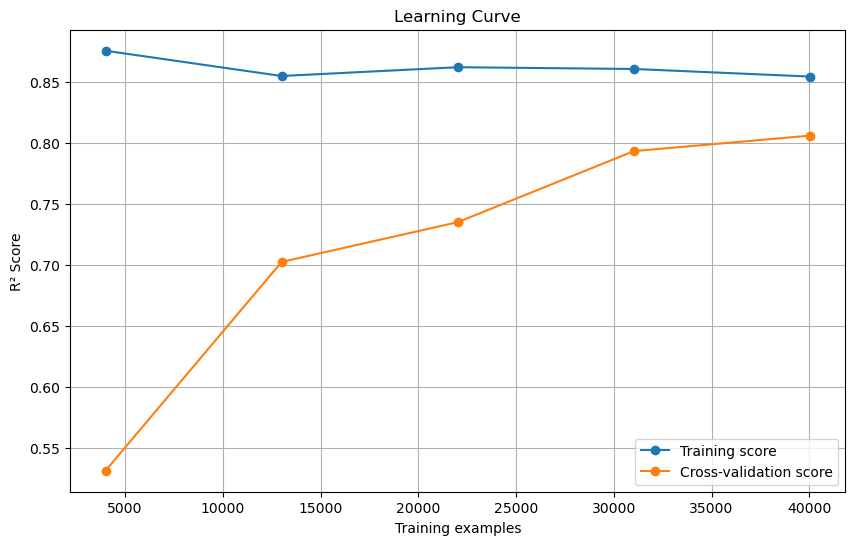

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, KFold

def plot_learning_curve(estimator, X, y):
    # Create KFold with shuffle=True
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring="r2"
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Run this with your best estimator after the search
plot_learning_curve(halving_search.best_estimator_, X, y)

In [ ]:
# # Train model WITHOUT sport data for comparison
# print("=" * 80)
# print("TRAINING MODEL WITHOUT SPORT DATA")
# print("=" * 80)

# # Drop sport columns from the dataframe
# df_no_sport = df.drop(columns=sport_cols_in_df, errors='ignore')
# print(f"Original df shape: {df.shape}")
# print(f"df without sport columns shape: {df_no_sport.shape}")

# # Recreate feature lists without sport columns
# numeric_features_no_sport = df_no_sport.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features_no_sport = df_no_sport.select_dtypes(include=['object', 'category']).columns.tolist()

# # Remove target and primary_key
# if 'target' in numeric_features_no_sport:
#     numeric_features_no_sport.remove('target')
# if 'primary_key' in numeric_features_no_sport:
#     numeric_features_no_sport.remove('primary_key')
# if 'primary_key' in categorical_features_no_sport:
#     categorical_features_no_sport.remove('primary_key')

# # Filter categorical features (< 100 categories)
# categorical_features_no_sport = [col for col in categorical_features_no_sport 
#                                   if df_no_sport[col].nunique() < max_categories]

# print(f"Numeric features: {len(numeric_features_no_sport)}")
# print(f"Categorical features: {len(categorical_features_no_sport)}")

# # Create preprocessor without sport columns
# preprocessor_no_sport = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features_no_sport),
#         ('cat', categorical_transformer, categorical_features_no_sport)
#     ])

# # Create pipeline without SportImputer but WITH FarmerImputer
# pipeline_no_sport = Pipeline(steps=[
#     ('activity_imputer', activity_imputer),
#     ('farmer_imputer', farmer_imputer),
#     ('preprocessor', preprocessor_no_sport),
#     ('regressor', HistGradientBoostingRegressor(random_state=42, max_iter=200))
# ])

# # Prepare data
# X_no_sport = df_no_sport.drop(columns=['target', 'primary_key'], errors='ignore')
# y_no_sport = df_no_sport['target']

# # Train-test split
# X_train_no_sport, X_test_no_sport, y_train_no_sport, y_test_no_sport = train_test_split(
#     X_no_sport, y_no_sport, test_size=0.2, random_state=42
# )

# # Train model
# print(f"\nTraining set size: {len(X_train_no_sport)}")
# print(f"Test set size: {len(X_test_no_sport)}")
# print("Fitting pipeline...")
# pipeline_no_sport.fit(X_train_no_sport, y_train_no_sport)
# print("✓ Model trained successfully")

# # Make predictions
# y_train_pred_no_sport = pipeline_no_sport.predict(X_train_no_sport)
# y_test_pred_no_sport = pipeline_no_sport.predict(X_test_no_sport)

# # Calculate metrics
# train_r2_no_sport = r2_score(y_train_no_sport, y_train_pred_no_sport)
# train_rmse_no_sport = np.sqrt(mean_squared_error(y_train_no_sport, y_train_pred_no_sport))
# train_mae_no_sport = mean_absolute_error(y_train_no_sport, y_train_pred_no_sport)

# test_r2_no_sport = r2_score(y_test_no_sport, y_test_pred_no_sport)
# test_rmse_no_sport = np.sqrt(mean_squared_error(y_test_no_sport, y_test_pred_no_sport))
# test_mae_no_sport = mean_absolute_error(y_test_no_sport, y_test_pred_no_sport)

# # Display results
# print("\n" + "=" * 80)
# print("MODEL PERFORMANCE (WITHOUT SPORT DATA)")
# print("=" * 80)
# print(f"\n{'Metric':<30} {'Train':<15} {'Test':<15}")
# print("-" * 80)
# print(f"{'R² Score':<30} {train_r2_no_sport:<15.4f} {test_r2_no_sport:<15.4f}")
# print(f"{'Root Mean Squared Error':<30} {train_rmse_no_sport:<15.4f} {test_rmse_no_sport:<15.4f}")
# print(f"{'Mean Absolute Error':<30} {train_mae_no_sport:<15.4f} {test_mae_no_sport:<15.4f}")
# print("=" * 80)

# if train_r2_no_sport - test_r2_no_sport > 0.1:
#     print(f"\n⚠️  Warning: Possible overfitting detected (train R² - test R² = {train_r2_no_sport - test_r2_no_sport:.4f})")
# else:
#     print(f"\n✓ Good generalization (train R² - test R² = {train_r2_no_sport - test_r2_no_sport:.4f})")

TRAINING MODEL WITHOUT SPORT DATA
Original df shape: (50044, 43)
df without sport columns shape: (50044, 38)
Numeric features: 5
Categorical features: 25

Training set size: 40035
Test set size: 10009
Fitting pipeline...
✓ Model trained successfully

MODEL PERFORMANCE (WITHOUT SPORT DATA)

Metric                         Train           Test           
--------------------------------------------------------------------------------
R² Score                       0.3986          0.3367         
Root Mean Squared Error        0.2376          0.2494         
Mean Absolute Error            0.1558          0.1607         

✓ Good generalization (train R² - test R² = 0.0619)


In [49]:
# Analysis: People with missing job_desc_current by Occupation_42
print("=" * 80)
print("ANALYSIS: MISSING JOB_DESC_CURRENT BY OCCUPATION_42")
print("=" * 80)

# Step 1: Filter people with missing job_desc_current
missing_job_desc = df[df['job_desc_current'].isna()].copy()
print(f"\n1. People with missing job_desc_current: {len(missing_job_desc)}")

# Step 2: Get unique Occupation_42 values from those with missing job_desc_current
occupation_values = missing_job_desc['Occupation_42'].dropna().unique()
print(f"\n2. Unique Occupation_42 values in missing group: {len(occupation_values)}")

# Step 3: For each Occupation_42, count people with same value but NON-missing job_desc_current
# and calculate mode of job columns
results = []

for occ in occupation_values:
    # Get people with this Occupation_42 who HAVE job_desc_current
    same_occ_with_job = df[(df['Occupation_42'] == occ) & (df['job_desc_current'].notna())].copy()
    
    # Count
    count_with_data = len(same_occ_with_job)
    
    # Calculate mode for all job_df columns (those ending with _current)
    mode_data = {'Occupation_42': occ, 'count_with_job_desc': count_with_data}
    
    if count_with_data > 0:
        # For each job column, calculate mode
        for col in job_cols_in_df:
            if col in same_occ_with_job.columns:
                mode_values = same_occ_with_job[col].mode()
                if len(mode_values) > 0:
                    mode_data[col] = mode_values.iloc[0]
                else:
                    mode_data[col] = None
    else:
        # No data available
        for col in job_cols_in_df:
            mode_data[col] = None
    
    results.append(mode_data)

# Create DataFrame
results_df = pd.DataFrame(results)

print(f"\n3. Results summary:")
print(f"   - Total Occupation_42 categories analyzed: {len(results_df)}")
print(f"   - Categories with reference data (count > 0): {(results_df['count_with_job_desc'] > 0).sum()}")
print(f"   - Categories with NO reference data (count = 0): {(results_df['count_with_job_desc'] == 0).sum()}")

# Display the table
print("\n" + "=" * 80)
print("RESULTS TABLE")
print("=" * 80)
print(f"\nShowing first 10 rows (total: {len(results_df)} rows):\n")
display(results_df.head(10))

print(f"\n✓ Full table stored in 'results_df' variable")
print(f"  Shape: {results_df.shape}")
print(f"  Columns: {list(results_df.columns)}")

ANALYSIS: MISSING JOB_DESC_CURRENT BY OCCUPATION_42

1. People with missing job_desc_current: 30708

2. Unique Occupation_42 values in missing group: 41

3. Results summary:
   - Total Occupation_42 categories analyzed: 41
   - Categories with reference data (count > 0): 24
   - Categories with NO reference data (count = 0): 17

RESULTS TABLE

Showing first 10 rows (total: 41 rows):



,Occupation_42,count_with_job_desc,job_desc_current,Work_condition_current,terms_of_emp_current,Earnings_current,OCCUPATIONAL_STATUS_current,ECONOMIC_SECTOR_current,EMPLOYER_TYPE_current,WORKING_HOURS_current,Job_dep_current,Employee_count_current,N3_current,N2_current,N1_current
0,csp_7_8,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
1,csp_7_4,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
2,csp_8_4,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
3,csp_7_5,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
4,csp_7_7,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
5,csp_6_7,936,676c,C,CDI,1082.0,O,NZ,ct_9,1820.0,59,tr_1,676c,csp_6_7,csp_6
6,csp_7_1,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
7,csp_8_5,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
8,csp_2_1,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
9,csp_3_5,113,352a,C,CDI,1307.0,O,JA,ct_9,1820.0,75,tr_6,352a,csp_3_5,csp_3



✓ Full table stored in 'results_df' variable
  Shape: (41, 15)
  Columns: ['Occupation_42', 'count_with_job_desc', 'job_desc_current', 'Work_condition_current', 'terms_of_emp_current', 'Earnings_current', 'OCCUPATIONAL_STATUS_current', 'ECONOMIC_SECTOR_current', 'EMPLOYER_TYPE_current', 'WORKING_HOURS_current', 'Job_dep_current', 'Employee_count_current', 'N3_current', 'N2_current', 'N1_current']


PERMUTATION IMPORTANCE ANALYSIS

Computing permutation importance (this may take a moment)...
✓ Permutation importance computed

TOP 30 MOST IMPORTANT FEATURES
                    feature  importance_mean  importance_std
                     Sports         0.898906        0.010447
                 department         0.231058        0.005955
            HIGHEST_DIPLOMA         0.148421        0.002863
              Occupation_42         0.124446        0.002444
                   AGE_2018         0.083881        0.003069
                        sex         0.052162        0.000777
              activity_type         0.039543        0.001786
    ECONOMIC_SECTOR_current         0.010114        0.000423
       terms_of_emp_current         0.009235        0.000532
            Job_dep_current         0.009002        0.000438
            Job_dep_retired         0.006236        0.000236
                 N2_retired         0.005791        0.000275
       Previous_dep_retired         0.005088   

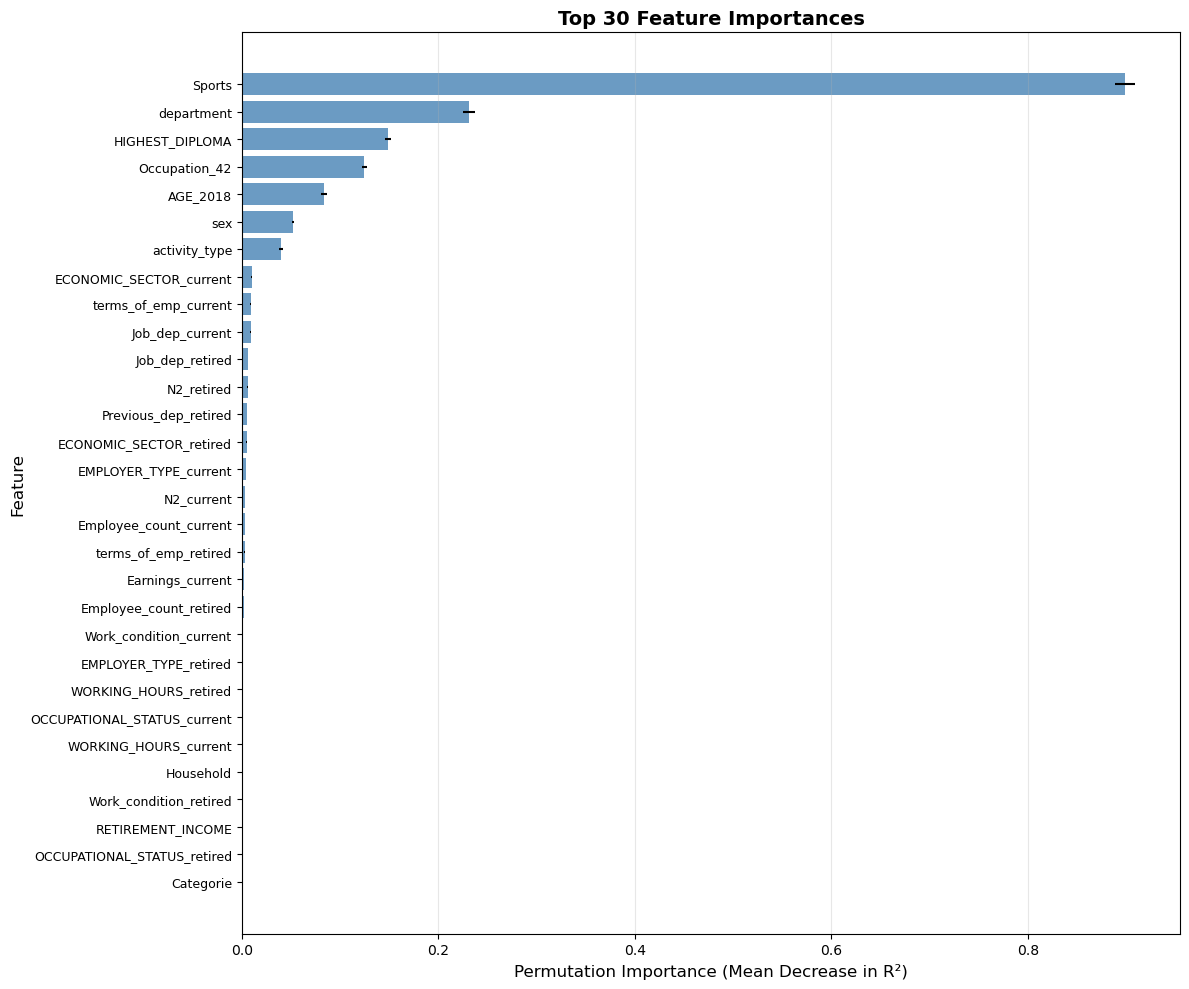


✓ Visualization complete for top 30 features

IMPORTANCE STATISTICS
Total features: 38
Features with positive importance: 31
Features with negative importance: 0
Features with near-zero importance (|imp| < 0.001): 16


In [47]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

print("=" * 80)
print("PERMUTATION IMPORTANCE ANALYSIS")
print("=" * 80)

# Compute permutation importance on test set
print("\nComputing permutation importance (this may take a moment)...")
perm_importance = permutation_importance(
    no_imputation_pipeline, 
    X_test, 
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

print("✓ Permutation importance computed")

# Get feature names from X_test (input features, not transformed)
feature_names = X_test.columns.tolist()

# Create dataframe with feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
})

# Sort by importance
importance_df = importance_df.sort_values('importance_mean', ascending=False)

# Display top 30 features
print("\n" + "=" * 80)
print("TOP 30 MOST IMPORTANT FEATURES")
print("=" * 80)
print(importance_df.head(30).to_string(index=False))

# Visualize top 30 features
top_n = 30
top_features = importance_df.head(top_n)

plt.figure(figsize=(12, 10))
plt.barh(range(len(top_features)), top_features['importance_mean'], 
         xerr=top_features['importance_std'], 
         align='center', alpha=0.8, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
plt.xlabel('Permutation Importance (Mean Decrease in R²)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete for top {top_n} features")

# Show summary statistics
print("\n" + "=" * 80)
print("IMPORTANCE STATISTICS")
print("=" * 80)
print(f"Total features: {len(importance_df)}")
print(f"Features with positive importance: {(importance_df['importance_mean'] > 0).sum()}")
print(f"Features with negative importance: {(importance_df['importance_mean'] < 0).sum()}")
print(f"Features with near-zero importance (|imp| < 0.001): {(importance_df['importance_mean'].abs() < 0.001).sum()}")

OUTLIER ANALYSIS - BADLY PREDICTED VALUES

Defining outlier categories...
--------------------------------------------------------------------------------
Absolute Error Statistics:
  Mean: 0.10
  Median: 0.08
  Std Dev: 0.09
  95th percentile: 0.27
  99th percentile: 0.39

Outlier Thresholds:
  Mean + 2*std: 0.28
  Mean + 3*std: 0.37

OUTLIER DISTRIBUTION
outlier_category
normal              9508
moderate_outlier     400
extreme_outlier      101
Name: count, dtype: int64

Percentages:
outlier_category
normal              94.99
moderate_outlier     4.00
extreme_outlier      1.01
Name: count, dtype: float64

EXTREME OUTLIERS ANALYSIS (Top 1%, n=101)

Top 10 worst predictions:
         actual  predicted  abs_error  pct_error  residual
48676  4.762244   3.668710   1.093534  22.962572  1.093534
37377  1.589090   2.522324   0.933234  58.727580 -0.933234
34370  3.946612   3.044801   0.901811  22.850250  0.901811
31360  4.505876   3.615464   0.890412  19.761136  0.890412
43674  3.007747   3.7

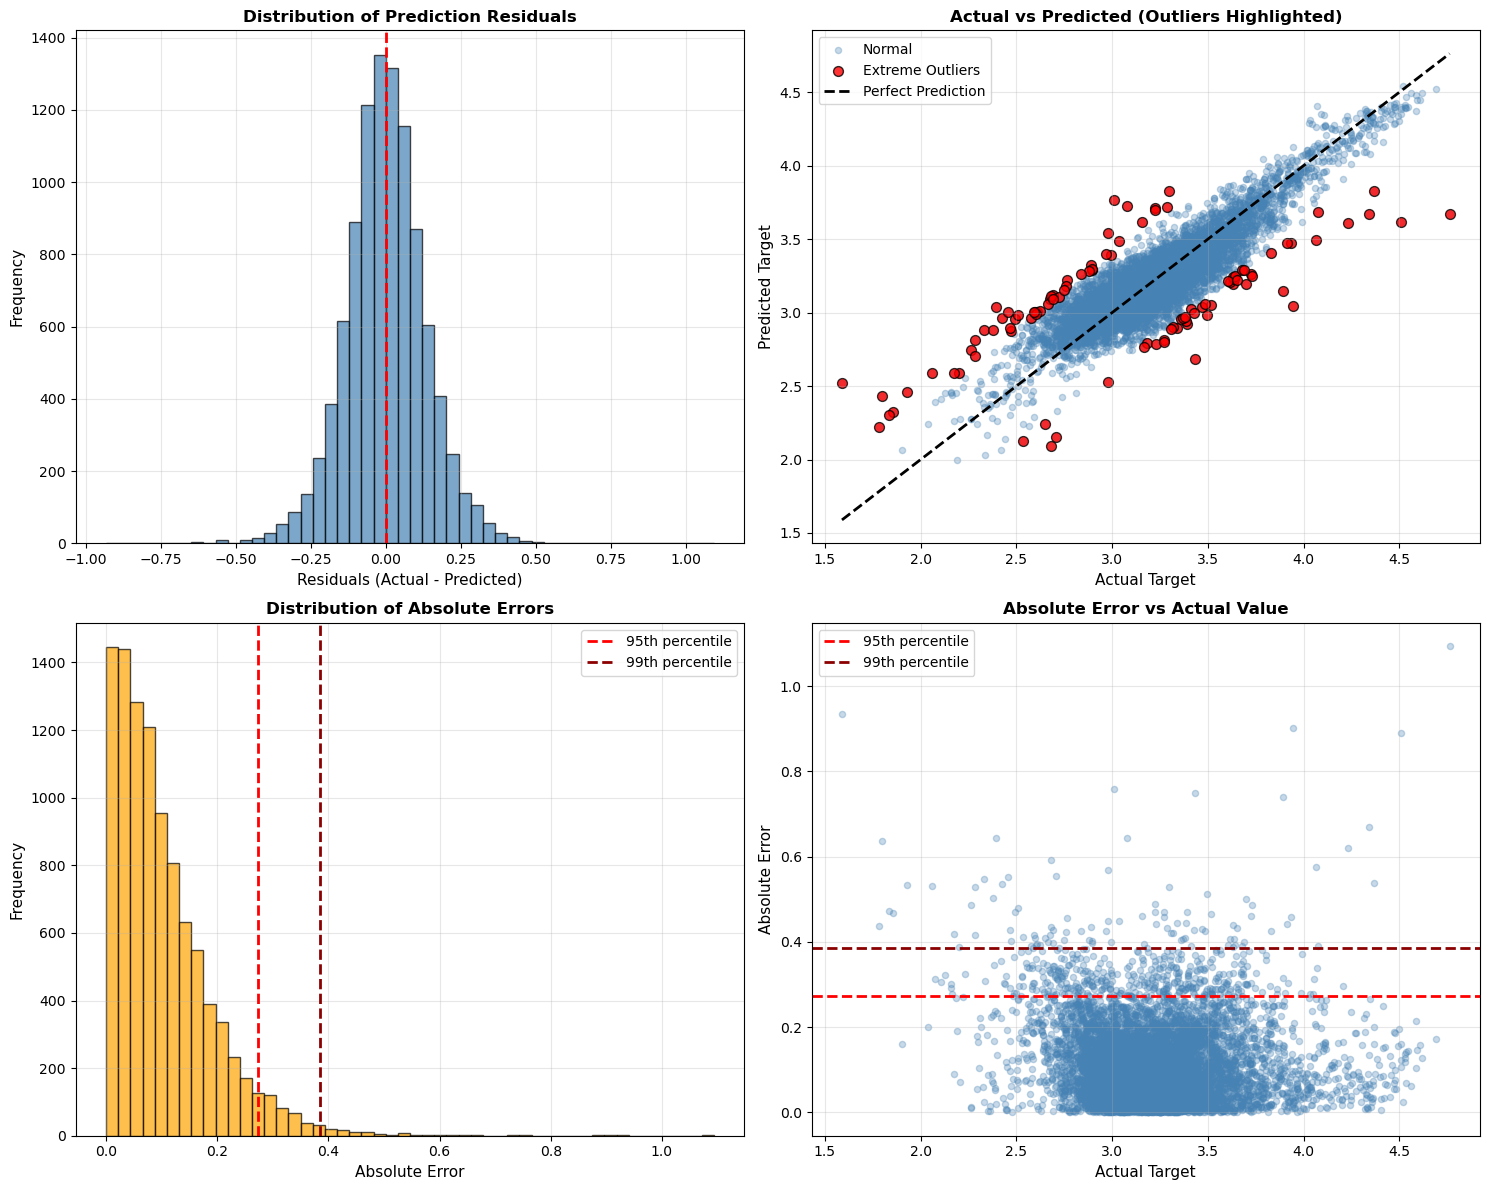


✓ Outlier analysis complete
✓ Outlier dataframe stored in 'outlier_df' variable with 10009 rows


In [50]:
print("=" * 80)
print("OUTLIER ANALYSIS - BADLY PREDICTED VALUES")
print("=" * 80)

# Calculate prediction errors (residuals)
test_residuals = y_test - y_test_pred
test_abs_errors = np.abs(test_residuals)
test_pct_errors = (test_abs_errors / y_test) * 100

# Create analysis dataframe
outlier_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred,
    'residual': test_residuals.values,
    'abs_error': test_abs_errors.values,
    'pct_error': test_pct_errors.values
}, index=y_test.index)

# Add features for analysis
outlier_df = pd.concat([outlier_df, X_test], axis=1)

# Define outlier thresholds
print("\nDefining outlier categories...")
print("-" * 80)

# Method 1: Based on percentiles of absolute error
p95_error = np.percentile(test_abs_errors, 95)
p99_error = np.percentile(test_abs_errors, 99)

# Method 2: Based on standard deviations
mean_error = test_abs_errors.mean()
std_error = test_abs_errors.std()
outlier_threshold_2std = mean_error + 2 * std_error
outlier_threshold_3std = mean_error + 3 * std_error

print(f"Absolute Error Statistics:")
print(f"  Mean: {mean_error:.2f}")
print(f"  Median: {np.median(test_abs_errors):.2f}")
print(f"  Std Dev: {std_error:.2f}")
print(f"  95th percentile: {p95_error:.2f}")
print(f"  99th percentile: {p99_error:.2f}")
print(f"\nOutlier Thresholds:")
print(f"  Mean + 2*std: {outlier_threshold_2std:.2f}")
print(f"  Mean + 3*std: {outlier_threshold_3std:.2f}")

# Categorize predictions
outlier_df['outlier_category'] = 'normal'
outlier_df.loc[outlier_df['abs_error'] > p95_error, 'outlier_category'] = 'moderate_outlier'
outlier_df.loc[outlier_df['abs_error'] > p99_error, 'outlier_category'] = 'extreme_outlier'

# Count outliers
print("\n" + "=" * 80)
print("OUTLIER DISTRIBUTION")
print("=" * 80)
outlier_counts = outlier_df['outlier_category'].value_counts()
print(outlier_counts)
print(f"\nPercentages:")
print((outlier_counts / len(outlier_df) * 100).round(2))

# Analyze extreme outliers
extreme_outliers = outlier_df[outlier_df['outlier_category'] == 'extreme_outlier'].copy()
print("\n" + "=" * 80)
print(f"EXTREME OUTLIERS ANALYSIS (Top 1%, n={len(extreme_outliers)})")
print("=" * 80)

if len(extreme_outliers) > 0:
    print("\nTop 10 worst predictions:")
    worst_predictions = extreme_outliers.nlargest(10, 'abs_error')[
        ['actual', 'predicted', 'abs_error', 'pct_error', 'residual']
    ]
    print(worst_predictions.to_string())
    
    # Analyze characteristics of extreme outliers
    print("\n" + "=" * 80)
    print("CHARACTERISTICS OF EXTREME OUTLIERS")
    print("=" * 80)
    
    # Categorical features analysis
    categorical_cols = ['activity_type', 'Occupation_42', 'HIGHEST_DIPLOMA', 
                       'Household', 'JOB_SECURITY', 'OCCUPATIONAL_STATUS_current']
    
    for col in categorical_cols:
        if col in extreme_outliers.columns:
            print(f"\n{col} distribution in extreme outliers:")
            value_counts = extreme_outliers[col].value_counts().head(5)
            print(value_counts)
    
    # Numeric features analysis
    numeric_cols = ['age', 'Earnings_current', 'WORKING_HOURS_current']
    
    print("\n" + "=" * 80)
    print("NUMERIC FEATURES - EXTREME OUTLIERS vs ALL DATA")
    print("=" * 80)
    for col in numeric_cols:
        if col in extreme_outliers.columns:
            outlier_mean = extreme_outliers[col].mean()
            all_mean = X_test[col].mean()
            outlier_median = extreme_outliers[col].median()
            all_median = X_test[col].median()
            print(f"\n{col}:")
            print(f"  Outliers - Mean: {outlier_mean:.2f}, Median: {outlier_median:.2f}")
            print(f"  All data - Mean: {all_mean:.2f}, Median: {all_median:.2f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuals distribution
axes[0, 0].hist(test_residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Prediction Residuals', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Actual vs Predicted with outliers highlighted
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.3, s=20, label='Normal', color='steelblue')
if len(extreme_outliers) > 0:
    axes[0, 1].scatter(extreme_outliers['actual'], extreme_outliers['predicted'], 
                      alpha=0.8, s=50, label='Extreme Outliers', color='red', edgecolor='black')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'k--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Target', fontsize=11)
axes[0, 1].set_ylabel('Predicted Target', fontsize=11)
axes[0, 1].set_title('Actual vs Predicted (Outliers Highlighted)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Absolute error distribution
axes[1, 0].hist(test_abs_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(x=p95_error, color='red', linestyle='--', linewidth=2, label='95th percentile')
axes[1, 0].axvline(x=p99_error, color='darkred', linestyle='--', linewidth=2, label='99th percentile')
axes[1, 0].set_xlabel('Absolute Error', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Error vs Actual value
axes[1, 1].scatter(y_test, test_abs_errors, alpha=0.3, s=20, color='steelblue')
axes[1, 1].axhline(y=p95_error, color='red', linestyle='--', linewidth=2, label='95th percentile')
axes[1, 1].axhline(y=p99_error, color='darkred', linestyle='--', linewidth=2, label='99th percentile')
axes[1, 1].set_xlabel('Actual Target', fontsize=11)
axes[1, 1].set_ylabel('Absolute Error', fontsize=11)
axes[1, 1].set_title('Absolute Error vs Actual Value', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Outlier analysis complete")
print(f"✓ Outlier dataframe stored in 'outlier_df' variable with {len(outlier_df)} rows")

In [ ]:
# Load test datasets
test_main_df = pd.read_csv("data/test_dataset.csv")
test_sport_df = pd.read_csv("data/test_dataset_sport.csv")
test_job_df = pd.read_csv("data/test_dataset_job.csv")
test_job_security_df = pd.read_csv("data/test_dataset_JOB_SECURITY.csv")
test_retired_former_df = pd.read_csv("data/test_dataset_retired_former.csv")
test_retired_jobs_df = pd.read_csv("data/test_dataset_retired_jobs.csv")
test_retired_pension_df = pd.read_csv("data/test_dataset_retired_pension.csv")

print(f"✓ Test datasets loaded:")
print(f"  - test_main_df: {test_main_df.shape}")
print(f"  - test_sport_df: {test_sport_df.shape}")
print(f"  - test_job_df: {test_job_df.shape}")
print(f"  - test_job_security_df: {test_job_security_df.shape}")
print(f"  - test_retired_former_df: {test_retired_former_df.shape}")
print(f"  - test_retired_jobs_df: {test_retired_jobs_df.shape}")
print(f"  - test_retired_pension_df: {test_retired_pension_df.shape}")

✓ Test datasets loaded:
  - test_main_df: (50042, 9)
  - test_sport_df: (6405, 2)
  - test_job_df: (19277, 11)
  - test_job_security_df: (24090, 2)
  - test_retired_former_df: (13316, 4)
  - test_retired_jobs_df: (11282, 11)
  - test_retired_pension_df: (11282, 2)


In [52]:
# Merge test datasets in the same way as training data
test_job_df = test_job_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
test_retired_jobs_df = test_retired_jobs_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
test_sport_df = test_sport_df.merge(sports_desc_df, left_on='Sports', right_on='Code', how='left')
test_sport_df = test_sport_df[['primary_key', 'Sports', 'Categorie']]

# Rename columns with meaningful suffixes before merging
test_job_df_renamed = test_job_df.rename(columns={col: f"{col}_current" for col in test_job_df.columns if col != 'primary_key'})
test_retired_jobs_df_renamed = test_retired_jobs_df.rename(columns={col: f"{col}_retired" for col in test_retired_jobs_df.columns if col != 'primary_key'})

# Merge test datasets
test_df = test_main_df.merge(test_job_df_renamed, on='primary_key', how='left')
test_df = test_df.merge(test_retired_jobs_df_renamed, on='primary_key', how='left')
test_df = test_df.merge(test_retired_pension_df, on='primary_key', how='left')
test_df = test_df.merge(test_sport_df, on='primary_key', how='left')
test_df['department'] = test_df['Insee_code'].str[:2]

# Column lists are already saved from training data merge
print(f"✓ Merged test datasets with meaningful suffixes:")
print(f"  - Test dataframe shape: {test_df.shape}")
print(f"  - Using same column lists from training data:")
print(f"    • Current job columns: {len(job_cols_in_df)} (suffix: _current)")
print(f"    • Retired job columns: {len(retired_cols_in_df)} (suffix: _retired)")
print(f"    • Pension columns: {len(pension_cols_in_df)}")
print(f"    • Sport columns: {len(sport_cols_in_df)}")

✓ Merged test datasets with meaningful suffixes:
  - Test dataframe shape: (50042, 39)
  - Using same column lists from training data:
    • Current job columns: 13 (suffix: _current)
    • Retired job columns: 13 (suffix: _retired)
    • Pension columns: 1
    • Sport columns: 2


In [53]:
# Train the best model from HalvingRandomSearchCV on the whole learning set
print("=" * 60)
print("TRAINING FINAL MODEL ON COMPLETE DATASET")
print("=" * 60)

# Get the best estimator from the search
final_model = halving_search.best_estimator_

print(f"\nBest parameters found:")
for param, value in halving_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation R² score: {halving_search.best_score_:.4f}")

# Train on the complete learning dataset
print(f"\nTraining on complete dataset with {len(X)} samples...")
final_model.fit(X, y)
print("✓ Final model trained successfully on complete learning set")

print("=" * 60)

TRAINING FINAL MODEL ON COMPLETE DATASET

Best parameters found:
  regressor__min_samples_leaf: 20
  regressor__max_leaf_nodes: 63
  regressor__max_iter: 200
  regressor__max_depth: 5
  regressor__learning_rate: 0.1
  regressor__l2_regularization: 0.0

Best cross-validation R² score: 0.7961

Training on complete dataset with 50044 samples...
✓ Final model trained successfully on complete learning set


In [56]:
# Make predictions on test dataset
print("=" * 60)
print("MAKING PREDICTIONS ON TEST DATASET")
print("=" * 60)

# Drop primary_key and target if they exist in test_df
X_test_final = test_df.drop(columns=['primary_key', 'target'], errors='ignore')

print(f"\nTest dataset shape: {X_test_final.shape}")
print("Making predictions...")

# Make predictions using the final trained model
test_predictions = final_model.predict(X_test_final)

# Create results dataframe
results_df = pd.DataFrame({
    'primary_key': test_df['primary_key'],
    'target': test_predictions
})

# Save to CSV
results_df.to_csv('predictions.csv', index=False)

print(f"✓ Predictions saved to 'predictions.csv'")
print(f"  - Number of predictions: {len(results_df)}")
print(f"  - Prediction statistics:")
print(f"    • Mean: {test_predictions.mean():.2f}")
print(f"    • Median: {np.median(test_predictions):.2f}")
print(f"    • Min: {test_predictions.min():.2f}")
print(f"    • Max: {test_predictions.max():.2f}")
print("=" * 60)

MAKING PREDICTIONS ON TEST DATASET

Test dataset shape: (50042, 38)
Making predictions...
✓ Predictions saved to 'predictions.csv'
  - Number of predictions: 50042
  - Prediction statistics:
    • Mean: 3.22
    • Median: 3.19
    • Min: 1.98
    • Max: 4.74
